<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1
!pip install tf-agents
!pip install tf-agents[reverb]

In [ ]:

import random
import math
import copy
import sys
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt


class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}


class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements != None:
            for i in startingElements: self.insert(i)

    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True

    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]
            else:
                return []
            output[1 if node.end else 0] += node.char
        return output if node.end else []

    def toGraph(self):
        from pyvis.network import Network
        g = Network(directed=True)
        g.show_buttons()

        nodeIndex = 1
        currentNode = 0
        q = [self.root]
        g.add_node(currentNode, label="", color="red")
        tempLabels = {0: ""}
        while q != []:
            n = q.pop(0)
            for i in n.children.values():
                tempLabels[nodeIndex] = tempLabels[currentNode] + i.char
                g.add_node(nodeIndex, label=tempLabels[currentNode] + i.char, color="#48e073" if i.end else "blue")
                g.add_edge(currentNode, nodeIndex)
                nodeIndex += 1
                q.append(i)
            currentNode += 1
        g.show('nx.html')


class MainGame:
    def __init__(self, sizeX=6, sizeY=6):  # Inicializa/resetea el juego
        self.sizeX = sizeX
        self.sizeY = sizeY
        self.objects = {".": [".", 0], "a": ["b", 1], "b": ["c", 5], "c": ["d", 25], "d": ["e", 125], "e": ["e", 625], "1": ["1", -25], "2": ["3", -5], "3": ["4", 50], "4": ["4", 500], "x": ["x", -50]}
        self.checkAndLoadFiles(1)
        self.turn = 0
        self.storage = "."
        self.bigFoots = [[(i,j), 0, False if self.matrix[i][j]=="1" else True] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j] in ("1", "2")]
        self.updateActual()
        self.score = [sum(self.objects[j][1] for i in self.matrix for j in i)]
        self.appearances = {i: 0 for i in self.objects.keys()}
        self.tr = Trie((''.join(chr(97 + int(j)) for j in str(i)) + str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
        self.tr.insert("exit")
        self.tr.insert("hint")
        self.tr.insert("*")
        # self.tr.toGraph() #Crea un grafo pyvis.network.Network del Trie usado para validar la entrada del usuario

    def checkAndLoadFiles(self, verbose=0):  # Carga desde ficheros, verbose=1 para mostrar mensajes de error, sino esta por defecto en 0
        try:
            with open("tablero.txt", "r") as f:
                self.matrix = []
                for i in f.readlines():
                    self.matrix.append([])
                    for j in i.replace("\n", ""):
                        if not j in self.objects: raise
                        self.matrix[-1].append(j)
        except:
            self.matrix = [random.sample(["."] * 45 + ["a"] * 18 + ["b"] * 4 + ["c"] * 3 + ["1"] * 2, self.sizeX) for i in range(self.sizeY)]
            print("Error al cargar el fichero tablero, usando tablero aleatorio...\U0001F92E" * verbose)
        try:
            with open("secuencia.txt", "r") as f:
                self.seq = ""
                for i in f.readline():
                    if i not in self.objects and i != "w": raise
                    self.seq += i
        except:
            self.seq = ""
            print("Error al cargar el fichero secuencia, usando secuencia aleatoria..." * verbose)

    def main(self):  # Función principal, 1 sola ejecución del juego
        print("Que empiece el juego:\U0001F609")
        self.showGame()
        while any("." in x for x in self.matrix):  # Mientras no haya casillas vacias en tablero
            # Obtener y validar entrada
            message = self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
            # message = self.validarEntrada("hint") #Modo de prueba del hint
            while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

            # Comprobar si es un mensaje especial y obtener coordenadas
            if "".join(message[1]) == "exit": break
            if "".join(message[1]) == "*": self.storage = self.actual; self.updateActual(); self.showGame(); continue;
            coordinates = (lambda l: (int("".join([str(ord(i) % 97) for i in l[0]])), int(l[1])))(message[1]) if "".join(message[1]) != "hint" else self.getHint()
            if not ((self.matrix[coordinates[0]][coordinates[1]] == ".") ^ (self.actual == "w")): print("Jugada errónea"); continue;

            # Ejecutar un movimiento del juego (step en caso de entorno gym.Env), en tiempo O((3+b)*n^2 + (n-1)*2n)+O(b*(4 + 6*n^2 + (n-1)*3n))
            self.updateMatrix(coordinates)
            self.turn += 1
            self.updateActual()            
            self.bigFoots = [[i[0], i[1] + 1, i[2]] for i in self.bigFoots]
            self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))

            # Renderizar juego y hacer gráfica de puntuación/apariciones de cada objeto
            self.showGame()
            for i in self.matrix:
                for j in i:
                    self.appearances[j] += 1
        print("Partida terminada, GG:\U0001F44F")
        self.plotScore()
        plt.bar(list(self.appearances.keys()), list(self.appearances.values()))

    def getHint(self):  # Obtener mejor jugada siguiente respecto a puntuación, casillas vacías y proximidad a BigFoots y objetos del mismo tipo, en tiempo O((1 + m + (3+b)*n^2 + (n-1)*2n + b*(4 + 6*n^2 + (n-1)*3n) + n^2 + )n^2)
        prevObjs = sum(4 - self.objects[b][1] for a in self.matrix for b in a if b != ".")
        tempValues = [-math.inf, (0, 0)]
        # debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
        for i in range(len(self.matrix)):
            for j in range(len(self.matrix[0])):
                if (self.matrix[i][j] == ".") ^ (self.actual == "w"):
                    newObj = copy.deepcopy(g)
                    newObj.updateMatrix((i, j))
                    newScore = sum(sum(self.objects[b][1] - 4 * (b != "." or 0) for b in a) for a in newObj.matrix) + prevObjs - 10 * newObj.minDistanceToElement((i, j), ["1", "2", newObj.matrix[i][j]])
                    if newScore > tempValues[0]: tempValues = [newScore, (i, j)]
                    # debugValues[i][j] = newScore
        # plt.imshow(debugValues, cmap='hot', interpolation='nearest')
        # plt.show()
        return tempValues[1]

    def plotScore(self, size=12):  # Hace una gráfica turnos/puntuación y un ajuste lineal
        x = np.array(list(range(len(self.score))))
        m, c = self.linReg(x, self.score)
        fig = plt.figure(figsize=(size, size))
        plt.plot(x, self.score)
        plt.plot(x, m * x + c)
        plt.show()

    def linReg(self, x, y):  # Hace cómodamente una regresión lineal con numpy
        return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]

    def minDistanceToElement(self, coordinates, elements):  # Función helper de self.hint(), se ejecuta en tiempo O(n^2 + (n-1)*2n) al estar también basado en BFS
        visited = set()
        q = [(coordinates, 0)]
        while q:
            n, distance = q.pop(0)
            if n in visited:
                continue
            visited.add(n)
            for i, j in ((n[0] - 1, n[1]), (n[0] + 1, n[1]), (n[0], n[1] - 1), (n[0], n[1] + 1)):
                if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]): continue
                if self.matrix[i][j] in elements: return distance + 1
                q.append(((i, j), distance + 1))
        return 0

    def updateActual(self):  # O(1)
        self.actual = random.choice(["a"] * 30 + ["b"] * 5 + ["c"] * 1 + ["1"] * 6 + ["w"] * 1) if self.seq == "" else self.seq[self.turn%len(self.seq)]

    def updateMatrix(self, coordinates):  # Actualiza el tablero con el elemento actual
        if self.actual == "w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
        self.matrix[coordinates[0]][coordinates[1]] = self.actual
        if self.actual == "1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

        self.checkAndColapse(coordinates)
        self.updateBigFoots()

    def checkAndColapse(self, coordinates):  # Comprobar colapsos de elementos en las coordenadas parámetro en tiempo O((3+b)*n^2 + (n-1)*2n)
        g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
        if g[1] == "2": coordinates = max(g[0], key=lambda x: [k for k in self.bigFoots if k[0] == x][0][1])
        while len(g[0]) > 2:
            for i in g[0]:
                if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
                self.matrix[i[0]][i[1]] = "."
            self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
            g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])

    def deleteBigFoot(self, coordinates):  # Borra el bigfoots que está en las coordenadas parámetro en tiempo O(b)
        for i in range(len(self.bigFoots)):
            if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

    def updateBigFoots(self):  # Actualiza los bigfoots con sus mecánicas de movimiento en tiempo O(b*(4 + 6*n^2 + (n-1)*3n))
        for i in enumerate(self.bigFoots):
            n = i[1][:]
            if not n[2] and n[1] >= 0:
                for j in ((n[0][0] - 1, n[0][1]), (n[0][0] - 1, n[0][1]+1), (n[0][0], n[0][1] + 1), (n[0][0]+1, n[0][1] + 1), (n[0][0] + 1, n[0][1]), (n[0][0] + 1, n[0][1]-1), (n[0][0], n[0][1] - 1), (n[0][0]-1, n[0][1] - 1)):
                    if j[0] < 0 or j[0] >= len(self.matrix) or j[1] < 0 or j[1] >= len(self.matrix[0]): continue
                    if self.matrix[j[0]][j[1]] == ".": self.matrix[j[0]][j[1]] = "1"; self.matrix[n[0][0]][n[0][1]] = "x" if n[1] > 10 else "."; self.bigFoots[i[0]][0] = j[:]; break;

            # Si no se ha movido el BigFoot porque no puede, intentar colapsarlo
            if n[0] == self.bigFoots[i[0]][0]:
                g = self.getGroup(n[0], True)
                if not "." in (self.matrix[k[0]][k[1]] for k in g):
                    for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0] == j][0]; self.bigFoots[bfIndex][2] = True;
                    self.checkAndColapse(n[0])

    def getGroup(self, coordinates, bigFootMode=False):  # Devuelve un grupo de coordenadas de celdas a partir de una origen usado BFS en tiempo O(n^2 + (n-1)*2n)
        visited = set()
        output = [coordinates]
        q = [coordinates]
        while q != []:
            n = q.pop(0)
            visited.add(n)
            for i in ((n[0] - 1, n[1]), (n[0] - 1, n[1]+1), (n[0], n[1] + 1), (n[0]+1, n[1]+1), (n[0] + 1, n[1]), (n[0]+1, n[1]-1), (n[0], n[1] - 1), (n[0] - 1, n[1]-1)):
                if i[0] < 0 or i[0] >= len(self.matrix) or i[1] < 0 or i[1] >= len(self.matrix[0]): continue
                if (not i in visited) and (self.matrix[i[0]][i[1]] == self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]] == ".")): q.append(i); output.append(i);
        return output

    def validarEntrada(self, s):
        s = self.tr.searchAndSplit(s)
        return (True if s else False, s)

    def showGame(self):  # Renderiza el tablero
        df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65 + int(j)) for j in str(i)) for i in range(len(self.matrix))])
        display(HTML(df.to_html()))
        print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")


if __name__ == "__main__":
    # random.seed(368) #311
    g = MainGame()
    g.main()
    sys.exit()

Que empiece el juego:😉


,0,1,2,3,4,5
A,.,2,2,2,.,b
B,a,b,b,c,a,b
C,a,a,a,c,.,b
D,a,a,d,a,a,b
E,a,a,d,a,a,b
F,b,b,b,b,b,b



Turno: 0 Puntos:363
Almacen: [.] Actual: [a]
Mover a casilla: c4


,0,1,2,3,4,5
A,.,2,2,2,.,.
B,.,b,b,.,.,.
C,.,.,.,.,d,.
D,.,.,d,.,.,.
E,.,.,d,.,.,.
F,.,.,.,.,.,.



Turno: 1 Puntos:370
Almacen: [.] Actual: [1]
Mover a casilla: a0


,0,1,2,3,4,5
A,.,2,2,2,.,.
B,1,b,b,.,.,.
C,.,.,.,.,d,.
D,.,.,d,.,.,.
E,.,.,d,.,.,.
F,.,.,.,.,.,.



Turno: 2 Puntos:345
Almacen: [.] Actual: [a]
Mover a casilla: c2


,0,1,2,3,4,5
A,1,2,2,2,.,.
B,.,b,b,.,.,.
C,.,.,a,.,d,.
D,.,.,d,.,.,.
E,.,.,d,.,.,.
F,.,.,.,.,.,.



Turno: 3 Puntos:346
Almacen: [.] Actual: [1]
Mover a casilla: b0


,0,1,2,3,4,5
A,1,2,2,2,.,.
B,.,b,b,.,.,.
C,.,1,a,.,d,.
D,.,.,d,.,.,.
E,.,.,d,.,.,.
F,.,.,.,.,.,.



Turno: 4 Puntos:321
Almacen: [.] Actual: [a]
Mover a casilla: d1


,0,1,2,3,4,5
A,.,2,2,2,.,.
B,1,b,b,.,.,.
C,.,.,a,.,d,.
D,1,a,d,.,.,.
E,.,.,d,.,.,.
F,.,.,.,.,.,.



Turno: 5 Puntos:322
Almacen: [.] Actual: [1]
Mover a casilla: a0


,0,1,2,3,4,5
A,.,2,2,2,.,.
B,1,b,b,.,.,.
C,1,1,a,.,d,.
D,.,a,d,.,.,.
E,.,.,d,.,.,.
F,.,.,.,.,.,.



Turno: 6 Puntos:297
Almacen: [.] Actual: [a]


KeyboardInterrupt: ignored

In [ ]:
import wx
import winsound
import random
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume

devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))
# Get current volume
currentVolumeDb = volume.GetMasterVolumeLevel()
volume.SetMasterVolumeLevel(-30, None)

class MainGame:
    def __init__(self, sizeX=6, sizeY=6):  # Inicializa/resetea el juego
        self.sizeX = sizeX
        self.sizeY = sizeY
        self.objects = {".": [".", 0], "a": ["b", 1], "b": ["c", 5], "c": ["d", 25], "d": ["e", 125], "e": ["e", 625], "1": ["1", -25], "2": ["3", -5], "3": ["4", 50], "4": ["4", 500], "x": ["x", -50]}
        self.turn = 0
        self.storage = "."
        self.checkAndLoadFiles()
        self.bigFoots = [[(i,j), 0, False if self.matrix[i][j]=="1" else True] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j] in ("1", "2")]
        self.updateActual()
        self.score = [sum(self.objects[j][1] for i in self.matrix for j in i)]

    def checkAndLoadFiles(self, fileName="fichero.txt", verbose=0):  # Carga desde ficheros, verbose=1 para mostrar mensajes de error, sino esta por defecto en 0
        try:
            with open(fileName, "r") as f:
                self.seq = ""
                for i in f.readline():
                    if i not in self.objects and i != "w": raise
                    self.seq += i
                self.matrix = []
                for i in f.readlines():
                    self.matrix.append([])
                    for j in i.replace("\n", ""):
                        if not j in self.objects: raise
                        self.matrix[-1].append(j)
        except:
            self.seq = ""
            self.matrix = [random.sample(["."] * 45 + ["a"] * 18 + ["b"] * 4 + ["c"] * 3 + ["1"] * 2, self.sizeX) for i in range(self.sizeY)]
            print("Error al cargar el fichero...\U0001F92E" * verbose)

    def main(self, coordinates):
        coordinates = (coordinates // len(self.matrix), coordinates - (coordinates // len(self.matrix))*len(self.matrix))
        if not ((self.matrix[coordinates[0]][coordinates[1]] == ".") ^ (self.actual == "w")): print("Jugada errónea"); return;

        # Ejecutar un movimiento del juego (step en caso de entorno gym.Env), en tiempo O((3+b)*n^2 + (n-1)*2n)+O(b*(4 + 6*n^2 + (n-1)*3n))
        self.updateMatrix(coordinates)
        self.turn += 1
        self.updateActual()
        self.bigFoots = [[i[0], i[1] + 1, i[2]] for i in self.bigFoots]
        self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))

    def updateActual(self):  # O(1)
        self.actual = random.choice(["a"] * 30 + ["b"] * 5 + ["c"] * 1 + ["1"] * 6 + ["w"] * 1) if self.seq == "" else self.seq[self.turn%len(self.seq)]

    def updateMatrix(self, coordinates):  # Actualiza el tablero con el elemento actual
        if self.actual == "w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
        self.matrix[coordinates[0]][coordinates[1]] = self.actual
        if self.actual == "1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

        self.checkAndColapse(coordinates)
        self.updateBigFoots()

    def checkAndColapse(self, coordinates):  # Comprobar colapsos de elementos en las coordenadas parámetro en tiempo O((3+b)*n^2 + (n-1)*2n)
        g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
        if g[1] == "2": coordinates = max(g[0], key=lambda x: [k for k in self.bigFoots if k[0] == x][0][1])
        while len(g[0]) > 2:
            for i in g[0]:
                if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
                self.matrix[i[0]][i[1]] = "."
            self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
            g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])

    def deleteBigFoot(self, coordinates):  # Borra el bigfoots que está en las coordenadas parámetro en tiempo O(b)
        for i in range(len(self.bigFoots)):
            if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

    def updateBigFoots(self):  # Actualiza los bigfoots con sus mecánicas de movimiento en tiempo O(b*(4 + 6*n^2 + (n-1)*3n))
        for i in enumerate(self.bigFoots):
            n = i[1][:]
            if not n[2] and n[1] > 0:
                for j in ((n[0][0]-1, n[0][1]), (n[0][0], n[0][1]+1), (n[0][0]+1, n[0][1]), (n[0][0], n[0][1]-1)):
                    if j[0] < 0 or j[0] >= len(self.matrix) or j[1] < 0 or j[1] >= len(self.matrix[0]): continue
                    if self.matrix[j[0]][j[1]] == ".": self.matrix[j[0]][j[1]] = "1"; self.matrix[n[0][0]][n[0][1]] = "x" if n[1] > 10 else "."; self.bigFoots[i[0]][0] = j[:]; break;

            # Si no se ha movido el BigFoot porque no puede, intentar colapsarlo
            if n[0] == self.bigFoots[i[0]][0]:
                g = self.getGroup(n[0], True)
                if not "." in (self.matrix[k[0]][k[1]] for k in g):
                    for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0] == j][0]; self.bigFoots[bfIndex][2] = True;
                    self.checkAndColapse(n[0])

    def getGroup(self, coordinates, bigFootMode=False):  # Devuelve un grupo de coordenadas de celdas a partir de una origen usado BFS en tiempo O(n^2 + (n-1)*2n)
        visited = set()
        output = [coordinates]
        q = [coordinates]
        while q != []:
            n = q.pop(0)
            visited.add(n)
            for i in ((n[0]-1, n[1]), (n[0], n[1]+1), (n[0]+1, n[1]), (n[0], n[1]-1)):
                if i[0] < 0 or i[0] >= len(self.matrix) or i[1] < 0 or i[1] >= len(self.matrix[0]): continue
                if (not i in visited) and (self.matrix[i[0]][i[1]] == self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]] == ".")): q.append(i); output.append(i);
        return output


class MyFrame(wx.Frame):
    def __init__(self, *args, **kwds):
        # begin wxGlade: MyFrame.__init__
        kwds["style"] = kwds.get("style", 0) | wx.DEFAULT_FRAME_STYLE
        wx.Frame.__init__(self, *args, **kwds)
        self.SetSize((969, 555))
        self.SetTitle("frame")

        self.window_1 = wx.SplitterWindow(self, wx.ID_ANY)
        self.window_1.SetMinimumPaneSize(20)

        self.window_1_pane_1 = wx.Panel(self.window_1, wx.ID_ANY)

        grid_sizer_1 = wx.GridSizer(5, 3, 0, 0)

        self.butonNewGame = wx.Button(self.window_1_pane_1, wx.ID_ANY, "Nueva Partida")
        grid_sizer_1.Add(self.butonNewGame, 0, 0, 0)

        self.checkboxLimite = wx.CheckBox(self.window_1_pane_1, wx.ID_ANY, "Limite de tiempo")
        grid_sizer_1.Add(self.checkboxLimite, 0, 0, 0)

        grid_sizer_1.Add((0, 0), 0, 0, 0)

        label_1 = wx.StaticText(self.window_1_pane_1, wx.ID_ANY, "Actual")
        grid_sizer_1.Add(label_1, 0, wx.ALIGN_BOTTOM, 0)

        grid_sizer_1.Add((0, 0), 0, 0, 0)

        label_2 = wx.StaticText(self.window_1_pane_1, wx.ID_ANY, "Almacén")
        grid_sizer_1.Add(label_2, 0, wx.ALIGN_BOTTOM, 0)

        self.actualButton = wx.BitmapButton(self.window_1_pane_1, wx.ID_ANY, wx.Bitmap(f"./Images/a.png", wx.BITMAP_TYPE_ANY))
        grid_sizer_1.Add(self.actualButton, 0, 0, 0)

        self.butonSwitch = wx.Button(self.window_1_pane_1, wx.ID_ANY, "Púlsame")
        grid_sizer_1.Add(self.butonSwitch, 0, 0, 0)

        self.storageButton = wx.BitmapButton(self.window_1_pane_1, wx.ID_ANY, wx.Bitmap(f"./Images/empty.png", wx.BITMAP_TYPE_ANY))
        grid_sizer_1.Add(self.storageButton, 0, 0, 0)

        label_3 = wx.StaticText(self.window_1_pane_1, wx.ID_ANY, "Puntuacion")
        grid_sizer_1.Add(label_3, 0, 0, 0)

        self.labelScore = wx.StaticText(self.window_1_pane_1, wx.ID_ANY, "0")
        self.labelScore.SetFont(wx.Font(29, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, "Segoe UI"))
        grid_sizer_1.Add(self.labelScore, 0, 0, 0)

        grid_sizer_1.Add((0, 0), 0, 0, 0)

        label_4 = wx.StaticText(self.window_1_pane_1, wx.ID_ANY, "Tiempo Restante")
        grid_sizer_1.Add(label_4, 0, 0, 0)

        self.labelTime = wx.StaticText(self.window_1_pane_1, wx.ID_ANY, "0")
        self.labelTime.SetFont(wx.Font(29, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, "Segoe UI"))
        grid_sizer_1.Add(self.labelTime, 0, 0, 0)
        grid_sizer_1.Add((0, 0), 0, 0, 0)
        self.window_1_pane_2 = wx.Panel(self.window_1, wx.ID_ANY)


        self.grid_sizer_2 = wx.GridSizer(6, 6, 0, 0)


        self.window_1_pane_2.SetSizer(self.grid_sizer_2)

        self.window_1_pane_1.SetSizer(grid_sizer_1)

        self.window_1.SplitVertically(self.window_1_pane_1, self.window_1_pane_2)

        self.Layout()

        self.Bind(wx.EVT_BUTTON, self.onCLick, self.butonNewGame)
        self.Bind(wx.EVT_BUTTON, self.switchStorage, self.butonSwitch)
        self.d = {}
        self.timer = wx.Timer(self)
        self.Bind(wx.EVT_TIMER, self.onTimer, self.timer)
        self.time = 5
        self.timer.Start(1000)
        # end wxGlade

    def onTimer(self, event):
        self.labelTime.SetLabelText(str(self.time))
        self.time-=1

        if self.time < 0: self.lose()

    def switchStorage(self, event):
        self.app.game.storage = self.app.game.actual
        self.app.game.updateActual()

        self.actualButton.SetBitmap(wx.Bitmap(f"./Images/{self.app.game.actual if self.app.game.actual != '.' else 'empty'}.png", wx.BITMAP_TYPE_ANY))
        self.actualButton.Refresh()
        self.storageButton.SetBitmap(wx.Bitmap(f"./Images/{self.app.game.storage if self.app.game.storage != '.' else 'empty'}.png", wx.BITMAP_TYPE_ANY))
        self.storageButton.Refresh()

    def lose(self):
        self.timer.Stop()
        winsound.MessageBeep(winsound.MB_ICONASTERISK)
        winsound.PlaySound('SystemHand', winsound.SND_ASYNC | winsound.SND_ALIAS)
        wx.MessageBox("El título", "Perdiste", wx.ICON_AUTH_NEEDED, self)

        for item in self.grid_sizer_2.GetChildren():
            button = item.GetWindow()
            if isinstance(button, wx.BitmapButton):
                button.Unbind(wx.EVT_BUTTON)
        self.grid_sizer_2.Clear()
        self.window_1_pane_2.DestroyChildren()

    def onCLick(self, event):  # wxGlade: MyFrame.<event_handler>
        print(event.GetEventObject().GetId(), dir(event.GetEventObject()))
        event.Skip()

    def buttonClick(self, event):  #Handler botones tablero
        self.app.game.main(event.GetEventObject().GetId())
        self.updateUI()
        if not any("." in x for x in self.app.game.matrix): self.lose(); event.Skip(); return;
        self.time = 5
        event.Skip()

    def updateUI(self):
        for item in self.grid_sizer_2.GetChildren():
            button = item.GetWindow()
            if isinstance(button, wx.BitmapButton):
                button.Unbind(wx.EVT_BUTTON)

        self.grid_sizer_2.Clear()
        self.window_1_pane_2.DestroyChildren()
        self.grid_sizer_2 = wx.GridSizer(len(self.app.game.matrix), len(self.app.game.matrix[0]), 0, 0)

        for i in range(len(self.app.game.matrix)):
            for j in range(len(self.app.game.matrix[0])):
                bitmap_button_1 = wx.BitmapButton(self.window_1_pane_2, len(self.app.game.matrix)*i + j, wx.Bitmap(f"./Images/{self.app.game.matrix[i][j] if self.app.game.matrix[i][j]!='.' else 'empty'}.png", wx.BITMAP_TYPE_ANY))

                if (len(self.app.game.matrix)*i + j) not in self.d:
                    self.d[len(self.app.game.matrix)*i + j] = "clickBind"
                    self.Bind(wx.EVT_BUTTON, self.buttonClick, bitmap_button_1)
                self.grid_sizer_2.Add(bitmap_button_1, 0, 0, 0)

        self.window_1_pane_2.SetSizer(self.grid_sizer_2)
        self.window_1_pane_2.Layout()

        self.actualButton.SetBitmap(wx.Bitmap(f"./Images/{self.app.game.actual if self.app.game.actual!='.' else 'empty'}.png", wx.BITMAP_TYPE_ANY))
        self.actualButton.Refresh()
        self.labelScore.SetLabelText(str(self.app.game.score[-1]))
    def buildReferenceApp(self, app):
        self.app = app
class MyApp(wx.App):
    def OnInit(self):
        self.frame = MyFrame(None, wx.ID_ANY, "")
        self.SetTopWindow(self.frame)
        self.frame.Show()
        self.frame.buildReferenceApp(self)
        self.game = MainGame()
        self.frame.updateUI()
        return True


if __name__ == "__main__":
    app = MyApp(0)
    app.MainLoop()

3
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2
A,.,.,.
B,.,.,a
C,.,.,.



Turno: 0 Puntos:1
Almacen: [.] Actual: [b]
(2, 0)
4
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3
A,.,.,.,a
B,a,a,.,c
C,b,.,c,.
D,a,.,.,.



Turno: 0 Puntos:59
Almacen: [.] Actual: [a]
(3, 1)
5
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4
A,.,.,c,1,.
B,c,.,.,.,.
C,1,c,.,.,b
D,.,.,.,.,.
E,.,.,1,.,.



Turno: 0 Puntos:5
Almacen: [.] Actual: [a]
(4, 0)
6
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5
A,b,a,a,.,b,a
B,.,.,a,.,.,.
C,a,.,.,.,a,.
D,a,c,a,.,a,.
E,.,.,a,.,a,a
F,a,.,.,.,.,.



Turno: 0 Puntos:48
Almacen: [.] Actual: [a]
(5, 1)
7
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6
A,1,c,.,.,.,.,a
B,.,a,.,.,.,.,a
C,.,a,a,.,.,.,.
D,a,.,a,a,.,a,.
E,.,.,c,.,.,a,.
F,b,.,.,.,.,a,1
G,a,a,.,a,.,.,.



Turno: 0 Puntos:19
Almacen: [.] Actual: [a]
(6, 2)
8
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7
A,.,.,.,a,.,1,b,.
B,.,.,.,.,a,.,a,a
C,.,.,.,a,a,.,c,a
D,a,.,.,1,.,a,.,a
E,.,c,b,.,.,b,.,.
F,.,.,.,b,.,.,.,.
G,.,.,.,.,c,c,.,a
H,b,.,a,.,.,a,b,.



Turno: 0 Puntos:93
Almacen: [.] Actual: [b]
(7, 1)
9
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8
A,a,1,b,a,.,.,a,.,a
B,b,a,a,.,1,a,.,.,.
C,.,c,.,.,.,b,.,.,.
D,a,.,c,b,.,a,.,a,.
E,c,b,.,a,c,.,.,a,.
F,.,.,.,.,.,a,.,a,.
G,.,a,b,.,a,.,.,a,.
H,.,a,.,.,.,.,c,a,a
I,.,a,.,a,.,.,a,a,.



Turno: 0 Puntos:129
Almacen: [.] Actual: [a]
(8, 0)
10
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,a,.,.,b,a,.
B,.,.,.,.,.,1,.,1,.,.
C,.,.,.,.,.,1,a,.,a,a
D,c,a,.,b,a,.,.,.,.,a
E,b,a,.,a,.,a,.,a,.,.
F,a,a,.,.,a,1,a,a,.,.
G,.,.,.,.,.,.,a,.,.,.
H,.,.,a,.,.,.,.,.,a,.
I,b,.,.,a,.,.,a,.,.,.
J,.,.,a,.,.,.,a,a,.,.



Turno: 0 Puntos:-29
Almacen: [.] Actual: [a]
(9, 0)
11
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10
A,a,a,a,.,.,.,a,a,.,.,.
B,.,.,.,.,a,.,.,.,b,.,.
C,.,.,.,.,.,.,a,a,.,.,.
D,.,a,.,.,a,.,b,.,.,a,.
E,.,.,.,.,.,a,a,.,.,.,.
F,.,.,a,a,.,a,.,.,a,c,.
G,.,.,.,.,a,a,.,b,.,.,.
H,a,.,1,.,.,a,.,.,a,.,.
I,b,a,a,.,.,.,.,.,.,.,a
J,.,a,.,.,1,b,.,.,.,.,.



Turno: 0 Puntos:36
Almacen: [.] Actual: [a]
(10, 1)
12
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11
A,c,1,.,.,.,.,.,.,.,a,a,.
B,c,.,.,.,.,.,c,b,.,.,a,.
C,a,.,.,a,.,a,.,a,.,.,a,.
D,.,.,.,a,a,.,c,a,a,.,.,a
E,.,.,.,.,1,.,.,.,.,.,a,a
F,b,1,.,a,a,.,.,.,.,a,.,.
G,.,.,.,.,.,.,.,.,1,a,.,.
H,.,.,a,b,a,a,.,a,.,.,b,.
I,c,.,.,.,.,b,.,a,.,.,a,.
J,.,a,a,.,.,.,.,c,.,b,.,.



Turno: 0 Puntos:114
Almacen: [.] Actual: [a]
(11, 0)
13
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12
A,a,a,.,.,a,a,.,a,a,.,.,a,.
B,.,.,.,a,c,c,.,a,.,.,.,.,.
C,b,a,.,.,.,.,a,.,b,.,.,.,.
D,.,.,.,.,.,c,.,c,a,.,a,.,.
E,.,.,.,.,.,.,a,.,a,.,1,.,.
F,.,a,a,a,.,.,.,.,.,.,.,.,a
G,.,.,.,.,a,.,.,.,a,b,a,a,a
H,.,.,.,.,.,1,a,.,.,.,a,a,a
I,a,a,.,.,.,.,a,.,.,.,.,a,.
J,a,.,a,.,.,.,c,a,.,.,b,.,.



Turno: 0 Puntos:127
Almacen: [.] Actual: [a]
(12, 0)
14
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
A,.,.,.,.,.,.,a,.,.,.,.,.,a,.
B,a,.,.,.,a,.,a,.,.,.,.,.,.,a
C,.,.,1,a,c,.,c,.,.,a,.,a,a,.
D,1,c,.,.,a,a,.,b,.,.,1,.,.,.
E,.,.,a,.,.,.,.,.,.,.,a,a,a,.
F,.,.,1,a,a,.,a,.,.,.,.,a,c,.
G,.,a,.,a,a,.,.,.,a,a,a,.,.,.
H,.,a,b,.,.,.,.,.,a,.,.,a,c,.
I,.,.,.,.,a,a,.,.,.,c,.,.,a,.
J,a,.,a,1,.,c,a,.,.,a,.,.,.,.



Turno: 0 Puntos:121
Almacen: [.] Actual: [a]
(13, 1)
15
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
A,.,.,a,.,.,a,.,.,a,.,.,1,.,.,.
B,.,b,.,.,.,a,.,.,.,a,.,.,.,.,a
C,.,.,a,a,b,c,a,a,.,.,.,.,.,a,a
D,a,a,.,.,a,.,.,.,.,a,b,.,.,1,.
E,.,.,a,.,.,.,.,.,a,a,a,.,c,.,a
F,.,.,.,a,a,.,b,.,.,.,.,.,c,a,.
G,.,.,.,.,.,b,.,a,.,.,1,.,a,.,.
H,b,c,c,.,.,a,.,a,.,.,.,.,.,.,.
I,.,.,a,a,.,a,.,a,a,.,.,a,c,b,.
J,c,.,.,.,.,b,a,a,.,.,.,.,.,.,c



Turno: 0 Puntos:252
Almacen: [.] Actual: [a]
(14, 0)
16
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
A,a,a,.,.,.,a,c,.,.,b,.,1,.,.,.,.
B,.,b,a,a,.,a,1,.,a,a,.,a,.,a,a,a
C,a,.,.,a,.,.,.,a,.,a,.,.,.,c,.,a
D,.,.,.,a,c,a,.,.,.,.,.,.,a,.,.,.
E,.,.,.,.,a,a,.,a,.,a,a,.,.,b,.,a
F,.,.,.,.,.,b,a,.,a,.,.,.,.,1,.,.
G,.,.,.,.,a,.,.,.,c,.,.,.,a,.,.,a
H,.,a,a,a,.,.,c,.,.,.,.,b,.,a,a,.
I,.,.,a,.,.,.,.,c,1,a,.,a,.,.,b,.
J,b,c,.,a,a,c,.,a,a,.,.,a,.,.,.,.



Turno: 0 Puntos:400
Almacen: [.] Actual: [a]
(15, 0)
17
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
A,a,1,.,b,a,a,a,a,.,.,a,.,.,a,.,a,c
B,.,.,.,.,.,.,a,.,a,.,a,.,a,1,.,.,.
C,a,.,b,b,.,1,.,a,a,.,.,.,.,.,.,.,a
D,.,.,.,a,.,a,a,a,.,a,.,a,1,.,a,a,.
E,b,.,a,.,.,a,.,a,b,a,.,.,.,.,.,.,a
F,.,.,a,.,.,a,.,a,.,.,a,a,1,a,.,.,.
G,.,.,.,.,.,a,.,.,.,a,a,a,.,a,.,.,.
H,.,.,a,.,a,.,a,.,.,.,.,b,1,.,a,b,.
I,1,.,.,.,a,.,a,.,.,.,b,.,a,.,.,.,a
J,.,.,.,.,a,.,.,a,.,c,.,.,a,a,.,a,.



Turno: 0 Puntos:94
Almacen: [.] Actual: [a]
(16, 0)
18
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
A,a,.,.,.,c,a,.,c,.,a,a,.,a,1,.,.,b,.
B,.,.,.,.,.,a,.,a,c,.,.,.,.,a,.,.,.,.
C,.,.,.,.,.,a,.,.,.,b,a,.,.,.,.,.,a,a
D,b,a,.,a,.,.,.,.,a,.,a,a,.,.,.,1,.,.
E,a,a,a,.,.,.,.,.,.,.,1,.,.,.,c,a,a,a
F,.,a,.,.,.,.,.,a,.,a,.,c,.,a,a,a,.,.
G,a,.,a,.,b,.,.,.,a,.,.,a,.,.,a,.,.,b
H,c,b,.,.,1,.,c,.,.,a,.,.,a,.,b,.,a,a
I,.,.,.,.,.,a,.,.,a,.,.,b,.,a,c,.,.,.
J,.,a,.,.,.,.,.,.,.,.,.,1,a,.,.,c,a,.



Turno: 0 Puntos:258
Almacen: [.] Actual: [b]
(17, 1)
19
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
A,.,.,a,.,.,.,.,a,.,.,.,.,1,.,.,a,b,.,.
B,a,.,.,.,.,.,b,a,a,.,1,.,.,a,.,.,a,.,a
C,b,a,a,b,.,c,a,.,.,a,.,a,.,a,.,.,a,a,.
D,.,.,a,.,.,a,.,.,.,a,a,.,.,.,.,.,c,.,.
E,.,a,a,.,.,b,1,a,.,.,b,.,.,a,.,.,.,.,.
F,.,1,.,.,.,a,.,.,.,a,.,.,.,.,.,.,.,c,b
G,.,.,a,.,.,b,.,.,1,.,a,a,.,.,.,.,a,.,.
H,.,a,.,.,b,.,a,1,.,.,.,.,.,a,c,a,.,a,a
I,.,.,a,a,.,a,b,.,a,.,b,.,.,.,.,.,a,.,.
J,a,a,.,1,.,.,.,b,.,a,.,a,.,.,.,.,a,.,b



Turno: 0 Puntos:238
Almacen: [.] Actual: [a]
(18, 0)
20
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A,.,.,.,.,.,a,.,c,b,.,a,.,a,.,a,a,.,.,a,1
B,.,a,a,.,b,.,.,a,.,.,c,.,.,a,.,a,.,.,.,.
C,.,.,.,.,.,a,c,.,c,a,.,.,.,a,.,.,.,.,c,.
D,.,.,.,c,.,.,b,.,.,.,a,.,.,.,.,a,b,.,.,.
E,.,a,.,.,.,.,.,1,a,a,a,.,.,.,.,.,.,.,a,.
F,.,.,.,.,.,a,1,.,b,a,.,.,.,b,.,.,.,a,b,1
G,a,a,.,.,.,a,.,.,.,.,c,.,a,a,.,a,a,.,1,.
H,.,.,a,.,.,a,c,1,a,b,.,.,.,.,a,a,a,.,.,.
I,.,.,c,.,a,1,b,.,b,.,.,1,.,a,a,.,b,.,.,a
J,a,b,.,.,.,1,a,a,.,.,.,c,.,a,a,a,c,.,b,.



Turno: 0 Puntos:254
Almacen: [.] Actual: [a]
(19, 0)
21
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
A,1,.,b,a,.,.,.,a,.,.,.,.,a,.,1,.,.,.,.,.,a
B,.,b,.,.,.,a,.,.,.,.,.,.,a,.,c,a,.,a,.,.,b
C,.,.,.,a,a,.,.,b,a,.,.,.,a,b,.,a,1,.,.,a,c
D,.,.,.,.,.,.,.,.,a,.,.,a,.,a,.,.,a,.,.,.,b
E,.,.,.,.,.,1,.,.,.,.,a,a,.,.,b,a,a,1,.,a,.
F,a,.,.,1,.,.,a,.,.,.,a,b,.,.,.,.,.,.,1,.,a
G,b,a,.,.,.,b,.,a,a,.,a,.,.,.,.,c,.,.,c,.,.
H,.,.,.,.,.,a,a,.,1,.,.,c,.,.,c,.,.,a,.,a,a
I,.,a,.,.,.,.,.,.,.,a,.,.,.,a,c,.,a,.,.,a,a
J,b,.,.,a,a,a,.,a,a,a,.,b,a,.,a,.,.,c,.,.,.



Turno: 0 Puntos:303
Almacen: [.] Actual: [a]
(20, 1)
22
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
A,a,a,.,1,a,a,b,.,.,.,a,.,a,b,.,.,.,a,a,.,.,.
B,.,a,.,a,b,a,.,.,.,.,.,.,b,.,.,.,.,a,a,a,1,.
C,.,.,.,.,.,a,.,.,a,.,b,.,.,.,.,a,.,a,.,.,.,a
D,b,a,.,a,b,a,.,.,.,.,c,.,.,.,a,a,.,.,b,.,.,.
E,.,a,a,a,a,.,.,.,.,.,.,.,.,.,.,c,.,.,a,a,.,a
F,.,b,a,a,1,.,a,b,.,b,.,.,a,.,.,a,.,.,.,a,.,a
G,.,.,.,.,.,.,.,.,.,a,.,a,.,1,.,.,.,.,a,a,b,a
H,a,c,a,.,.,.,.,.,.,.,c,.,c,a,b,a,.,.,a,a,.,.
I,.,c,.,.,.,a,a,c,.,.,.,.,.,a,a,.,.,1,.,.,.,.
J,a,a,.,a,a,.,c,a,.,b,.,.,.,.,.,a,.,.,a,.,.,.



Turno: 0 Puntos:303
Almacen: [.] Actual: [1]
(21, 1)
23
Error al cargar el fichero tablero, usando tablero aleatorio...🤮
Error al cargar el fichero secuencia, usando secuencia aleatoria...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
A,c,.,a,.,.,.,.,.,.,a,b,.,.,.,.,a,.,c,.,.,.,.,.
B,.,.,a,.,.,1,.,.,.,a,.,.,.,a,a,.,c,.,a,a,.,.,.
C,a,.,b,.,.,b,.,.,.,a,1,.,a,.,a,.,.,c,a,.,.,.,a
D,.,.,.,b,.,.,.,a,.,a,.,.,.,.,.,b,b,.,.,.,.,.,c
E,.,c,a,.,.,a,.,a,.,.,.,.,.,a,1,b,.,.,.,.,.,a,b
F,.,.,a,a,.,.,b,.,a,b,a,a,.,.,.,.,a,b,.,.,1,c,a
G,a,.,a,.,b,.,.,.,a,.,.,a,a,a,.,.,.,.,a,.,.,.,a
H,.,.,.,.,.,1,.,.,a,.,.,a,.,.,a,.,.,c,.,.,.,.,b
I,.,1,.,b,.,a,.,.,.,a,.,a,.,.,a,.,.,a,a,a,.,.,a
J,.,1,.,.,a,b,.,.,a,a,a,.,.,.,c,a,a,a,.,a,.,.,.



Turno: 0 Puntos:250
Almacen: [.] Actual: [a]
(22, 0)


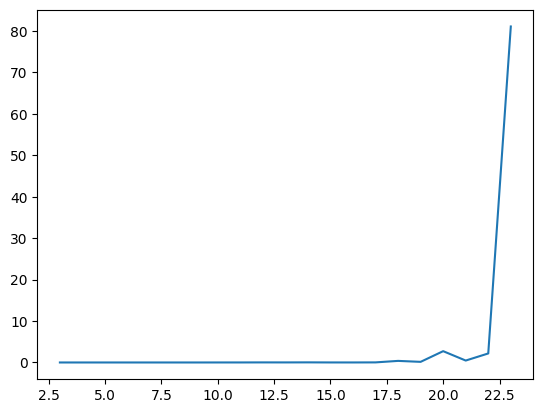

In [ ]:
import time

l = []
r = range(3, 24)
for i in r:
    print(i)
    g = MainGame(i, i)
    coordinates = (0, 0)
    for i in range(len(g.matrix)):
        for j in range(len(g.matrix[0])):
            if ((g.matrix[i][j]==".") ^ (g.actual=="w")): coordinates = (i,j); break;
    g.showGame()
    print(coordinates)
    t1 = time.time()
    g.updateMatrix(coordinates)
    g.updateActual()
    g.turn+=1
    g.bigFoots = [[i[0], i[1]+1, i[2]] for i in g.bigFoots]
    
    t2 = time.time()
    l.append(t2-t1)

#plt.figure()
plt.plot(list(r), l)

##**Bot Encoding**

In [ ]:
import gym
import tensorflow as tf
import tf_agents
from tf_agents.trajectories import time_step as ts

In [ ]:
class GameEnv(gym.Env, MainGame):
    def __init__(self, goal_velocity=0):
        self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
        self.storage="."
        self.verbose = False
        self.viewer = None        

        self.action_space = gym.spaces.Box( low=0, high=1, shape=(36,), dtype=np.float32 ) 
        self.observation_space = gym.spaces.Box( low=0, high=123, shape=(37,), dtype=np.float32 )

        self.score = []
        self.seed()
        self.reset()
        self.batched=self.reset

        self.state_log = []

    def seed(self, seed=None):
        random.seed()
        gym.utils.seeding.np_random()
    
    def getState(self):
        return np.array([ord(i) for i in np.array(self.matrix).reshape(36).tolist()]+[ord(self.actual)])

    def step(self, action):
        for i in range(len(self.matrix)):
          for j in range(len(self.matrix[0])):
            action[6*i+j]*=((self.matrix[i][j]==".") ^ (self.actual=="w"))
        action = action.argmax()
        self.last_action = action

        coordinates = (action//6 if action!=36 else 5, action%6)
        # perform move and get new state
        try:
            reward = sum(self.objects[j][1] for i in self.matrix for j in i)
            self.updateMatrix(coordinates)
            self.updateActual()
            self.turn+=1
            self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
            self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
            reward = self.score[-1]-reward#+self.linReg(np.array(list(range(len(self.score)))), self.score)[0]*len(self.score)   
            reward = reward*12 if reward<0 else min(1, reward)     
            done = not (any("." in x for x in self.matrix))
        except:
            reward = 0
            done = True  
        reward+=5          
        return self.getState(), reward, done, {}

    def reset(self):
        if random.randint(0, 1000)%4 == 0: self.plotScore(4)
        self.seed()
        self.checkAndLoadFiles()
        self.turn = 0
        self.score = []
        self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
        self.updateActual()
        return self.getState()

    def close(self):
        pass

env_name = 'main-env'
gym.envs.registration.register(id=env_name,entry_point=f'{__name__}:GameEnv')
env = gym.make(env_name)

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment main-env
  logger.warn(f"Overriding environment {id}")


**Experiment 1**

<ipython-input-2-d260a5a2e859>:151: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]


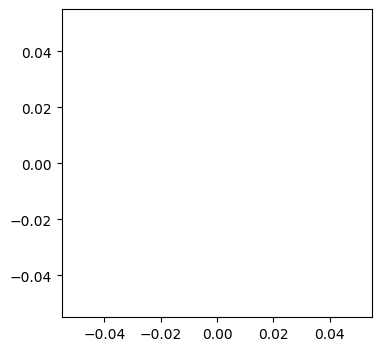

In [ ]:
env = tf_agents.environments.suite_gym.load(env_name)
env.reset()
#env.showGame()

train_py_env = tf_agents.environments.suite_gym.load(env_name)
eval_py_env = tf_agents.environments.suite_gym.load(env_name)

train_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(eval_py_env)

def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

actor_fc_layers = (1000, 500)
critic_obs_fc_layers = (600,)
critic_action_fc_layers = None
critic_joint_fc_layers = (1200,)
ou_stddev = 0.2
ou_damping = 0.15
target_update_tau = 0.05
target_update_period = 5
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.8
reward_scale_factor = 1.0
gradient_clipping = None

actor_learning_rate = 0.0001
critic_learning_rate = 0.001
debug_summaries = False
summarize_grads_and_vars = False

global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = tf_agents.agents.ddpg.actor_network.ActorNetwork(
    train_env.time_step_spec().observation,
    train_env.action_spec(),
    fc_layer_params=actor_fc_layers,
)

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = tf_agents.agents.ddpg.critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)

tf_agent = tf_agents.agents.ddpg.ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()

In [ ]:
dir(tf.compat.v1.losses)

['Reduction',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'absolute_difference',
 'add_loss',
 'compute_weighted_loss',
 'cosine_distance',
 'get_losses',
 'get_regularization_loss',
 'get_regularization_losses',
 'get_total_loss',
 'hinge_loss',
 'huber_loss',
 'log_loss',
 'mean_pairwise_squared_error',
 'mean_squared_error',
 'sigmoid_cross_entropy',
 'softmax_cross_entropy',
 'sparse_softmax_cross_entropy']

step = 13720: loss = 79.77313232421875


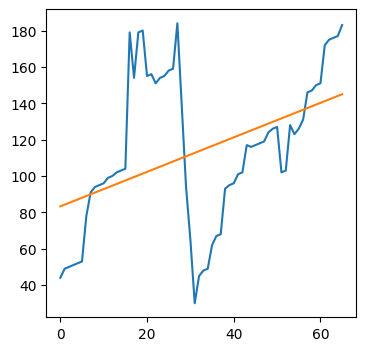

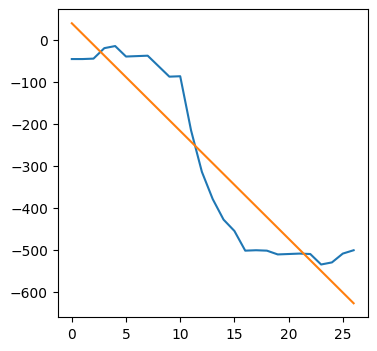



step = 13730: loss = 86.22489166259766
step = 13740: loss = 59.81267166137695


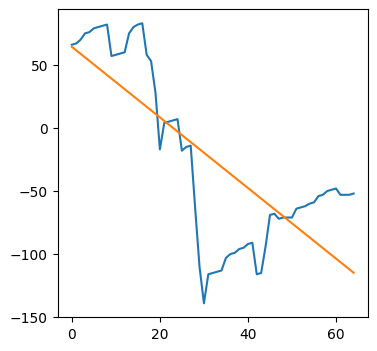





step = 13750: loss = 75.50517272949219


step = 13760: loss = 105.39818572998047
step = 13770: loss = 90.05206298828125


step = 13780: loss = 82.17589569091797
step = 13790: loss = 134.03871154785156


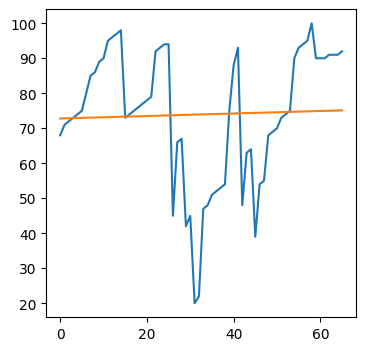



step = 13800: loss = 106.74332427978516


step = 13810: loss = 70.97455596923828


step = 13820: loss = 108.3039321899414


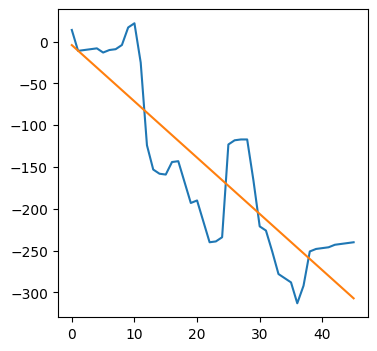



step = 13830: loss = 101.69988250732422


step = 13840: loss = 81.38105773925781


step = 13850: loss = 90.58744049072266
step = 13860: loss = 104.86060333251953


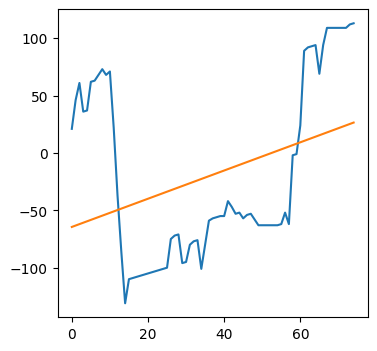



step = 13870: loss = 58.85779571533203




step = 13880: loss = 106.68382263183594


step = 13890: loss = 90.27616119384766
step = 13900: loss = 92.81962585449219


step = 13910: loss = 93.14143371582031


step = 13920: loss = 89.3561782836914


step = 13930: loss = 63.547794342041016




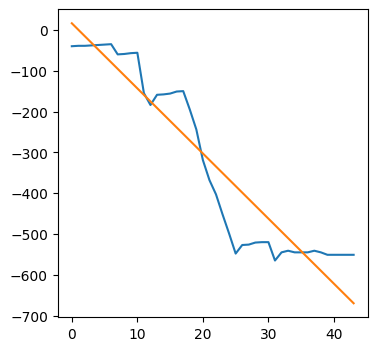



step = 13940: loss = 81.69829559326172


step = 13950: loss = 107.42379760742188


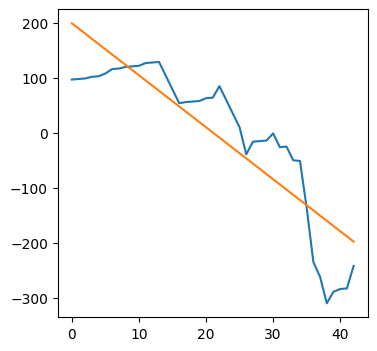



step = 13960: loss = 120.04542541503906


step = 13970: loss = 114.71685791015625


step = 13980: loss = 70.30567169189453


step = 13990: loss = 113.8840560913086
step = 14000: loss = 62.607723236083984


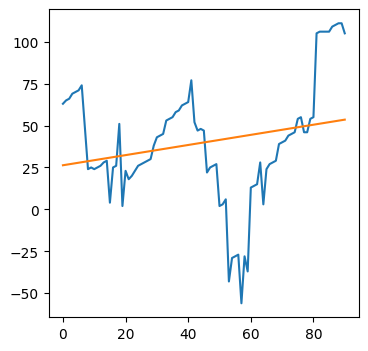



step = 14010: loss = 65.60350799560547


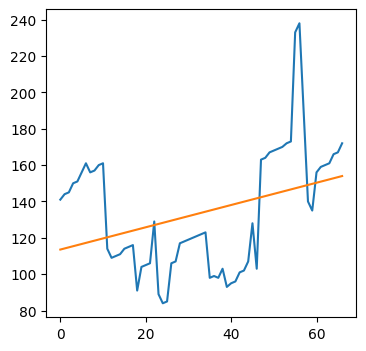



step = 14020: loss = 82.85594940185547


step = 14030: loss = 95.25112915039062
step = 14040: loss = 109.83584594726562


step = 14050: loss = 71.71674346923828


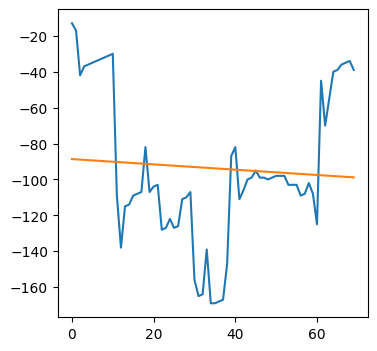



step = 14060: loss = 108.80766296386719
step = 14070: loss = 76.9892807006836


step = 14080: loss = 78.18999481201172


step = 14090: loss = 116.33523559570312


step = 14100: loss = 90.78531646728516
step = 14110: loss = 98.40099334716797


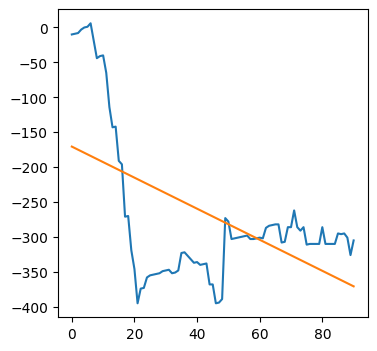



step = 14120: loss = 82.33384704589844


step = 14130: loss = 87.7728271484375


step = 14140: loss = 121.99720001220703
step = 14150: loss = 115.75004577636719


step = 14160: loss = 102.45532989501953


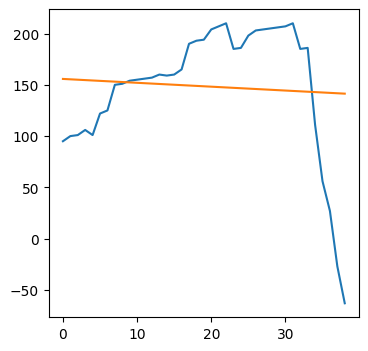



step = 14170: loss = 100.04197692871094


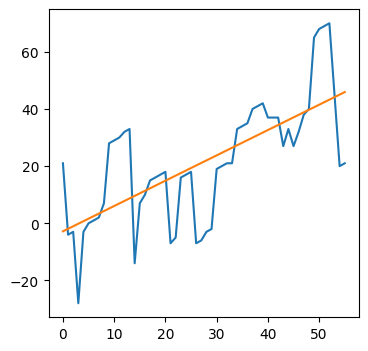



step = 14180: loss = 62.819129943847656


step = 14190: loss = 125.89473724365234


step = 14200: loss = 120.07901763916016


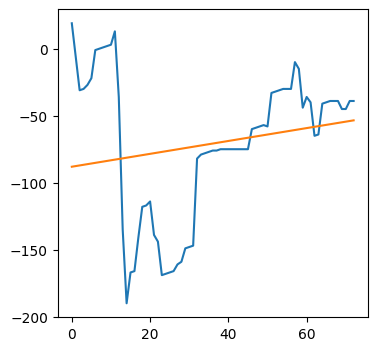



step = 14210: loss = 117.07504272460938
step = 14220: loss = 89.03264617919922


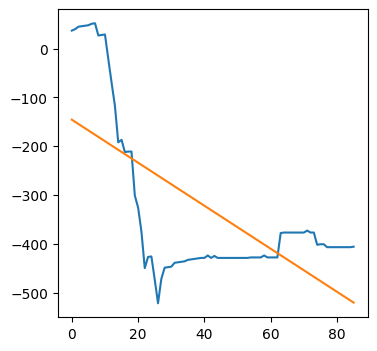



step = 14230: loss = 115.72266387939453


step = 14240: loss = 98.0852279663086
step = 14250: loss = 89.5535659790039


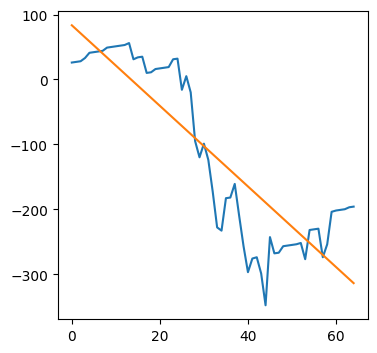



step = 14260: loss = 95.06749725341797


step = 14270: loss = 117.44151306152344


step = 14280: loss = 114.35797119140625


step = 14290: loss = 96.91400909423828
step = 14300: loss = 140.31997680664062




step = 14310: loss = 76.82537841796875


step = 14320: loss = 75.54447937011719


step = 14330: loss = 120.06473541259766


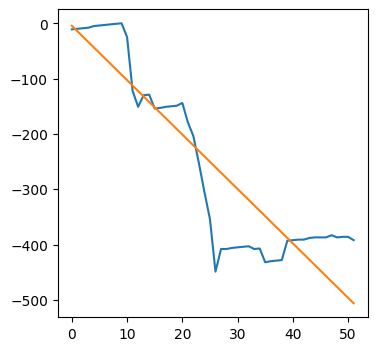



step = 14340: loss = 93.6841049194336


step = 14350: loss = 67.25674438476562
step = 14360: loss = 85.89694213867188


step = 14370: loss = 93.28841400146484


step = 14380: loss = 118.87206268310547
step = 14390: loss = 98.04122924804688


step = 14400: loss = 98.29771423339844


step = 14410: loss = 93.52252197265625


step = 14420: loss = 81.53191375732422
step = 14430: loss = 89.65139770507812


step = 14440: loss = 96.7869873046875


step = 14450: loss = 80.73560333251953
step = 14460: loss = 87.61624908447266


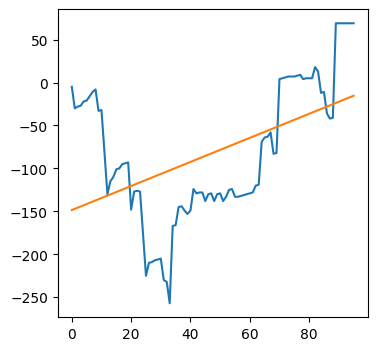



step = 14470: loss = 83.81626892089844


step = 14480: loss = 77.9604263305664


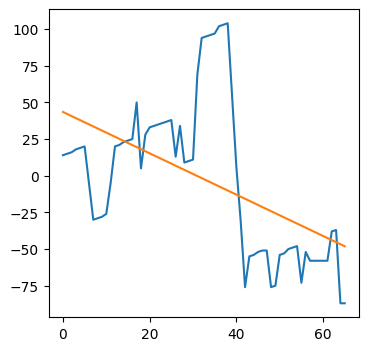



step = 14490: loss = 101.60938262939453


step = 14500: loss = 132.0706329345703
step = 14510: loss = 92.30160522460938


step = 14520: loss = 121.54025268554688
step = 14530: loss = 89.81768798828125


step = 14540: loss = 107.10460662841797


step = 14550: loss = 96.61827087402344


step = 14560: loss = 84.04289245605469
step = 14570: loss = 88.39341735839844




step = 14580: loss = 72.95206451416016


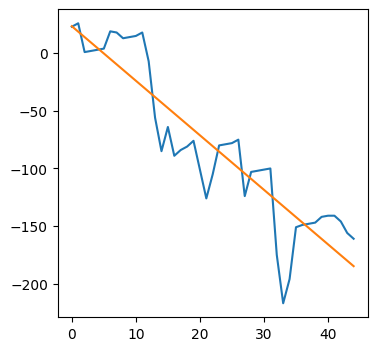



step = 14590: loss = 68.87248229980469


step = 14600: loss = 66.12217712402344
step = 14610: loss = 83.71492767333984


step = 14620: loss = 109.64476013183594


step = 14630: loss = 103.75221252441406


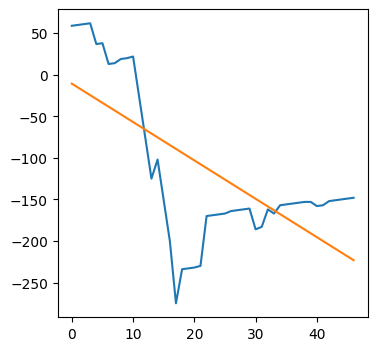



step = 14640: loss = 85.7313003540039
step = 14650: loss = 99.88111114501953


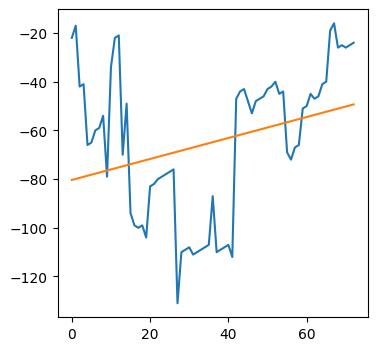



step = 14660: loss = 70.80630493164062


step = 14670: loss = 132.23397827148438


step = 14680: loss = 108.91142272949219


step = 14690: loss = 85.71617126464844


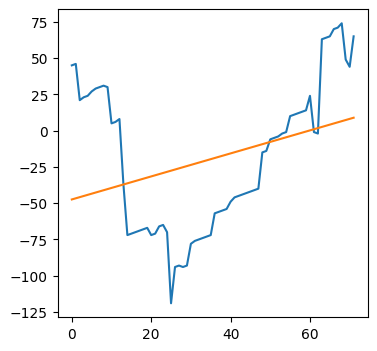



step = 14700: loss = 107.8953628540039


step = 14710: loss = 106.42074584960938


step = 14720: loss = 105.61365509033203


step = 14730: loss = 90.07484436035156


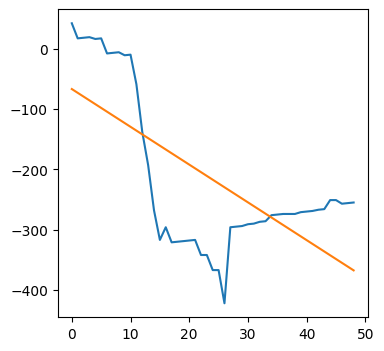



step = 14740: loss = 67.74267578125


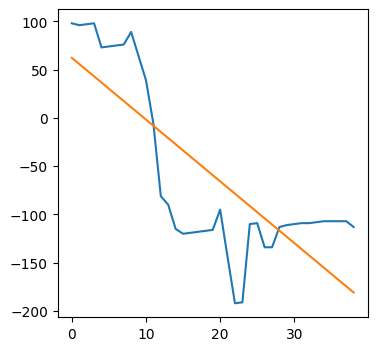



step = 14750: loss = 151.54754638671875


step = 14760: loss = 71.50426483154297


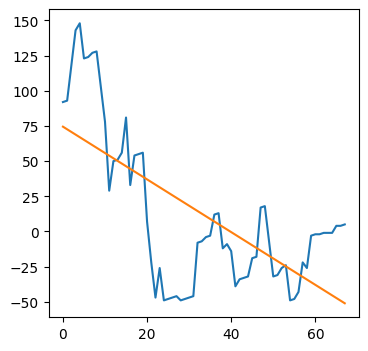



step = 14770: loss = 103.53433990478516


step = 14780: loss = 85.72589874267578


step = 14790: loss = 83.63185119628906


step = 14800: loss = 115.54008483886719


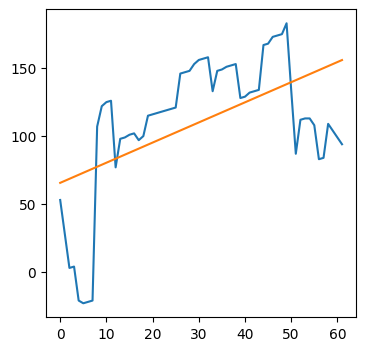



step = 14810: loss = 86.3476791381836


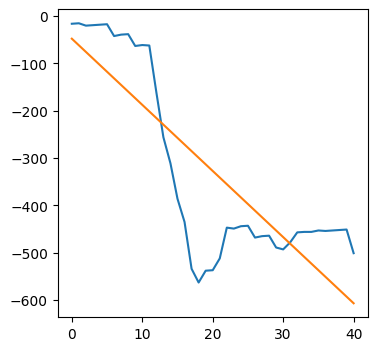



step = 14820: loss = 87.02975463867188


step = 14830: loss = 81.10636901855469


step = 14840: loss = 77.37396240234375


step = 14850: loss = 61.7069091796875


step = 14860: loss = 99.32878875732422


step = 14870: loss = 129.9971923828125
step = 14880: loss = 78.30174255371094


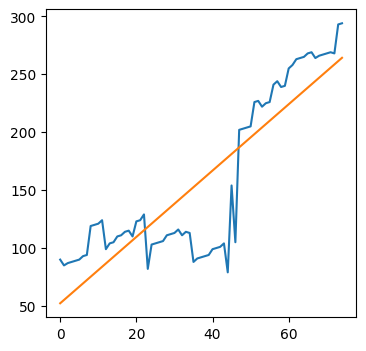



step = 14890: loss = 124.30369567871094




step = 14900: loss = 133.02557373046875
step = 14910: loss = 87.23165893554688


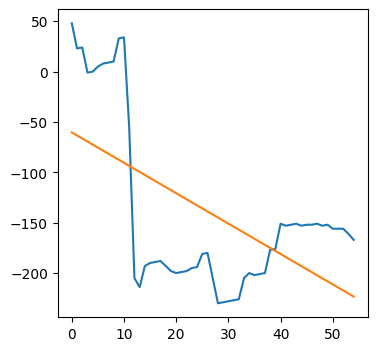



step = 14920: loss = 116.50386810302734


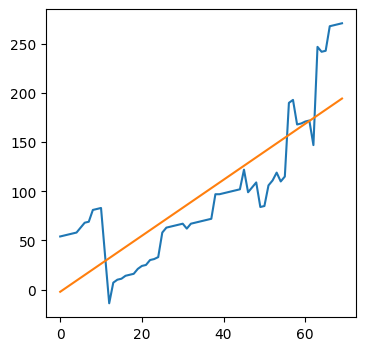



step = 14930: loss = 106.75568389892578


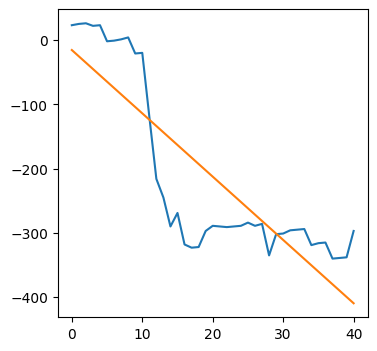



step = 14940: loss = 89.97107696533203


step = 14950: loss = 105.06253051757812


step = 14960: loss = 105.45313262939453


step = 14970: loss = 89.81922912597656
step = 14980: loss = 79.17784118652344


step = 14990: loss = 126.46147918701172


step = 15000: loss = 70.0470199584961


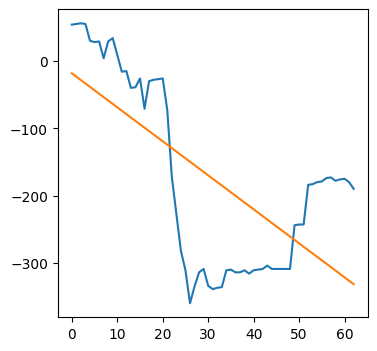



step = 15010: loss = 79.99519348144531


step = 15020: loss = 88.40795135498047
step = 15030: loss = 85.1636962890625


step = 15040: loss = 121.3746566772461
step = 15050: loss = 109.9462661743164


step = 15060: loss = 64.98072814941406


step = 15070: loss = 128.41322326660156


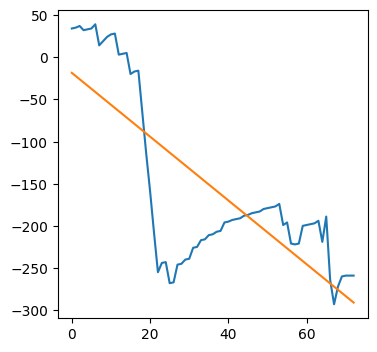



step = 15080: loss = 71.36762237548828


step = 15090: loss = 81.81752014160156


step = 15100: loss = 95.28498840332031


step = 15110: loss = 74.01749420166016
step = 15120: loss = 84.10960388183594


step = 15130: loss = 87.72711944580078


step = 15140: loss = 97.31267547607422
step = 15150: loss = 74.77200317382812


step = 15160: loss = 99.65573120117188


step = 15170: loss = 114.28362274169922


step = 15180: loss = 91.17345428466797


step = 15190: loss = 83.64969635009766


step = 15200: loss = 69.9009017944336


step = 15210: loss = 157.2529296875


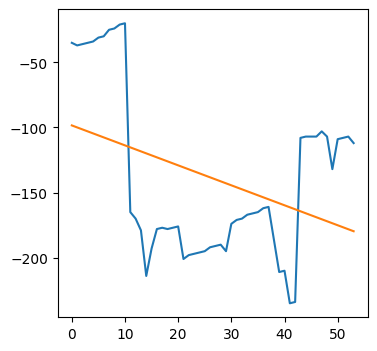



step = 15220: loss = 67.49373626708984
step = 15230: loss = 92.39051055908203


step = 15240: loss = 78.46292114257812


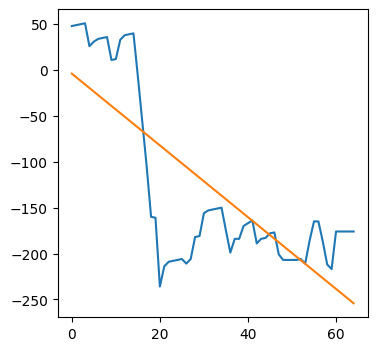



step = 15250: loss = 89.93461608886719


step = 15260: loss = 89.78593444824219
step = 15270: loss = 73.26368713378906




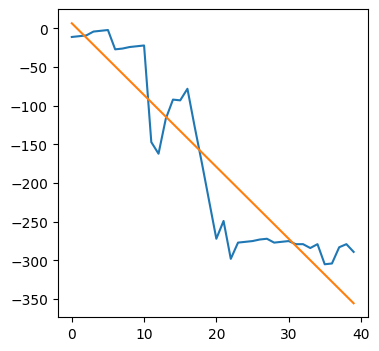



step = 15280: loss = 99.31454467773438


step = 15290: loss = 104.26942443847656
step = 15300: loss = 106.52029418945312


step = 15310: loss = 118.86653900146484


step = 15320: loss = 85.38192749023438


step = 15330: loss = 106.9593505859375
step = 15340: loss = 103.25457763671875


step = 15350: loss = 68.1026840209961


step = 15360: loss = 110.26194763183594


step = 15370: loss = 115.53703308105469


step = 15380: loss = 67.62494659423828


step = 15390: loss = 65.89130401611328


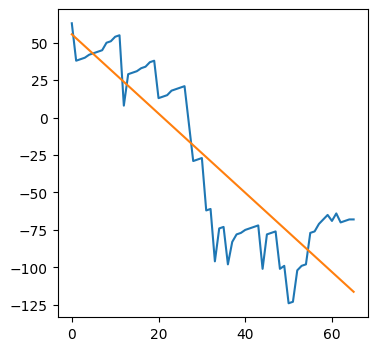



step = 15400: loss = 60.946563720703125
step = 15410: loss = 123.17830657958984




step = 15420: loss = 119.73013305664062


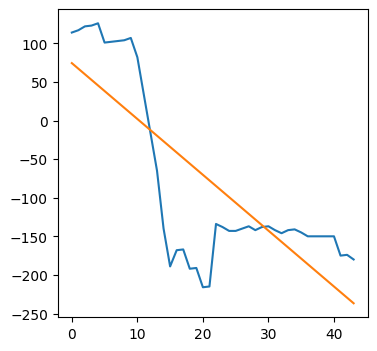



step = 15430: loss = 69.25614166259766


step = 15440: loss = 80.43524932861328


step = 15450: loss = 73.72314453125
step = 15460: loss = 65.13016510009766


step = 15470: loss = 115.30809020996094


step = 15480: loss = 115.1849365234375
step = 15490: loss = 77.81141662597656


step = 15500: loss = 71.03682708740234


step = 15510: loss = 102.10668182373047


step = 15520: loss = 99.27011108398438
step = 15530: loss = 89.6940689086914


step = 15540: loss = 63.38523864746094


step = 15550: loss = 78.62691497802734


step = 15560: loss = 91.17520904541016
step = 15570: loss = 67.71536254882812


step = 15580: loss = 98.94628143310547


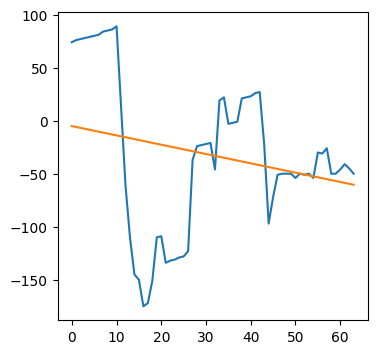



step = 15590: loss = 72.20507049560547


step = 15600: loss = 61.960350036621094


step = 15610: loss = 86.05777740478516
step = 15620: loss = 113.75403594970703
step = 15630: loss = 84.25678253173828


step = 15640: loss = 98.7552719116211


step = 15650: loss = 86.2381362915039


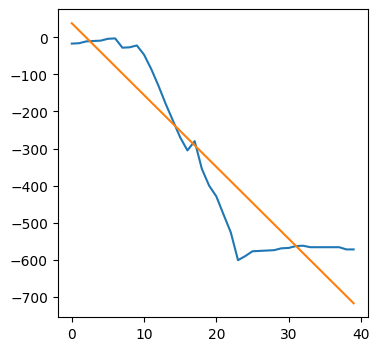





step = 15660: loss = 87.05049133300781


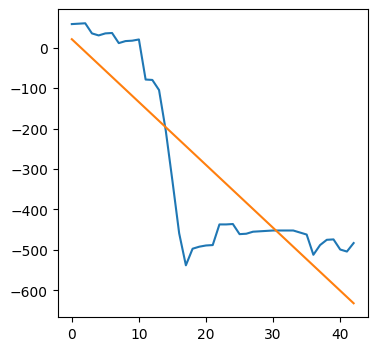



step = 15670: loss = 71.8257827758789


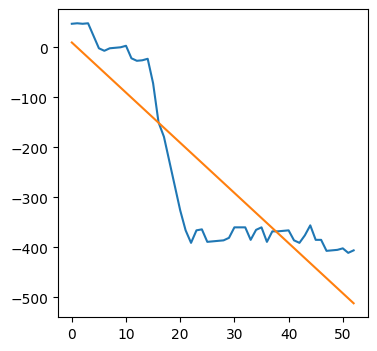



step = 15680: loss = 86.5676498413086
step = 15690: loss = 82.31749725341797


step = 15700: loss = 87.2208023071289


step = 15710: loss = 109.11271667480469


step = 15720: loss = 93.45819854736328


step = 15730: loss = 84.83859252929688


step = 15740: loss = 116.72301483154297


step = 15750: loss = 104.3521728515625


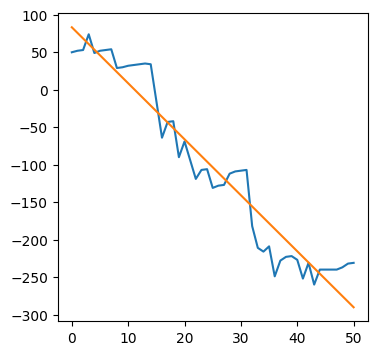



step = 15760: loss = 82.14797973632812


step = 15770: loss = 99.69610595703125
step = 15780: loss = 79.15715789794922


step = 15790: loss = 109.37474060058594


step = 15800: loss = 104.85065460205078


step = 15810: loss = 92.46246337890625


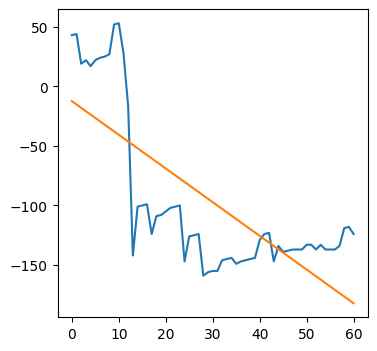



step = 15820: loss = 95.30863952636719


step = 15830: loss = 105.61703491210938


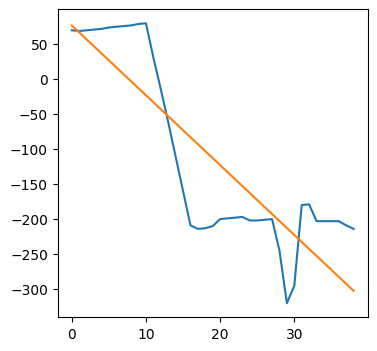



step = 15840: loss = 67.52197265625


step = 15850: loss = 84.52973937988281


step = 15860: loss = 106.40109252929688
step = 15870: loss = 86.34722900390625


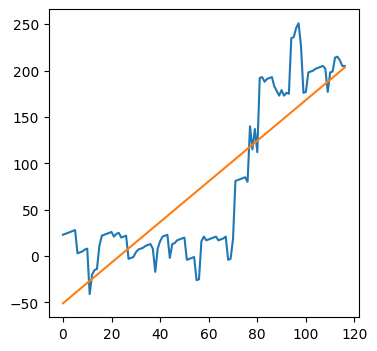



step = 15880: loss = 54.53424072265625
step = 15890: loss = 79.72911834716797




step = 15900: loss = 55.75830841064453
step = 15910: loss = 96.75529479980469


step = 15920: loss = 132.8340301513672


step = 15930: loss = 76.24029541015625
step = 15940: loss = 88.4847183227539


step = 15950: loss = 104.41523742675781


step = 15960: loss = 79.78495788574219
step = 15970: loss = 104.02452087402344


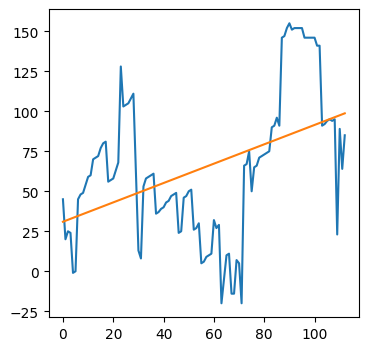



step = 15980: loss = 96.06487274169922


step = 15990: loss = 101.41500854492188


step = 16000: loss = 92.30475616455078


step = 16010: loss = 75.76644134521484
step = 16020: loss = 73.7010269165039
step = 16030: loss = 77.59488677978516


step = 16040: loss = 92.9288330078125


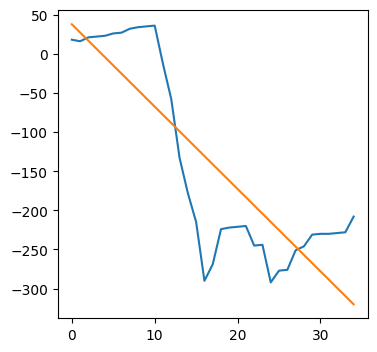





step = 16050: loss = 71.10136413574219


step = 16060: loss = 103.5871353149414


step = 16070: loss = 91.03462982177734
step = 16080: loss = 97.94491577148438


step = 16090: loss = 95.32546997070312


step = 16100: loss = 98.3822250366211


step = 16110: loss = 75.25030517578125


step = 16120: loss = 65.28761291503906


step = 16130: loss = 95.85307312011719


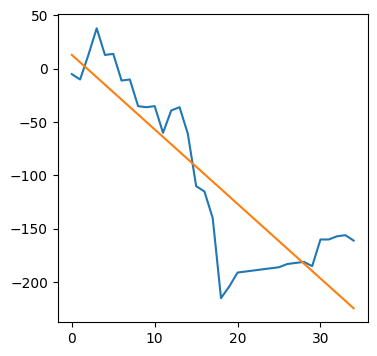



step = 16140: loss = 84.86853790283203


step = 16150: loss = 83.72270965576172
step = 16160: loss = 67.81153869628906


step = 16170: loss = 55.71574783325195


step = 16180: loss = 78.12112426757812


step = 16190: loss = 132.1313934326172


step = 16200: loss = 101.67813110351562
step = 16210: loss = 76.73687744140625
step = 16220: loss = 61.456642150878906


step = 16230: loss = 127.93208312988281


step = 16240: loss = 65.5672836303711


step = 16250: loss = 66.97957611083984
step = 16260: loss = 71.61323547363281




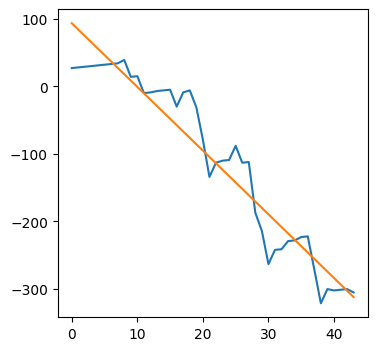



step = 16270: loss = 80.45037841796875
step = 16280: loss = 69.59089660644531


step = 16290: loss = 70.1930160522461


step = 16300: loss = 92.62255859375


step = 16310: loss = 136.7589874267578


step = 16320: loss = 60.74885177612305
step = 16330: loss = 79.51983642578125


step = 16340: loss = 95.67047882080078


step = 16350: loss = 94.1799087524414


step = 16360: loss = 73.68768310546875


step = 16370: loss = 87.65315246582031
step = 16380: loss = 107.79713439941406


step = 16390: loss = 74.00231170654297


step = 16400: loss = 93.1236572265625
step = 16410: loss = 84.28643798828125


step = 16420: loss = 92.5331039428711




step = 16430: loss = 111.62039184570312


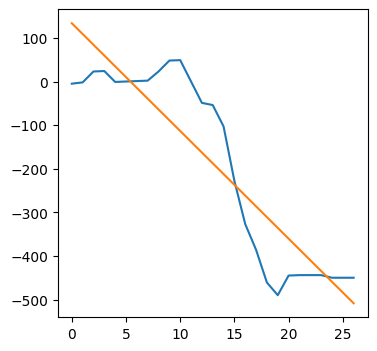



step = 16440: loss = 78.84699249267578


step = 16450: loss = 69.56501770019531


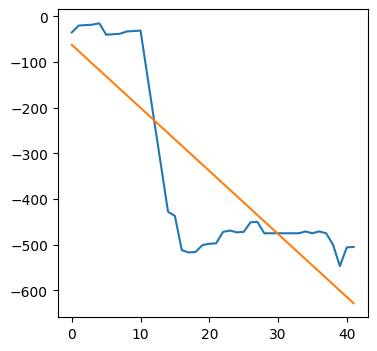



step = 16460: loss = 81.5977554321289


step = 16470: loss = 66.80123138427734


step = 16480: loss = 121.22186279296875


step = 16490: loss = 82.9268569946289


step = 16500: loss = 108.77825927734375
step = 16510: loss = 117.21815490722656


step = 16520: loss = 58.60401916503906


step = 16530: loss = 78.7252426147461


step = 16540: loss = 63.57021713256836


step = 16550: loss = 82.0083999633789
step = 16560: loss = 110.97504425048828


step = 16570: loss = 81.38540649414062


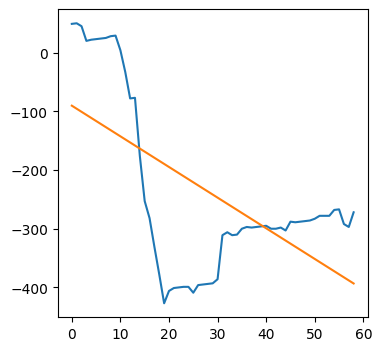



step = 16580: loss = 48.10554504394531


step = 16590: loss = 145.01156616210938


step = 16600: loss = 98.14783477783203
step = 16610: loss = 96.89876556396484


step = 16620: loss = 88.66903686523438




step = 16630: loss = 109.40296936035156
step = 16640: loss = 111.43199157714844


step = 16650: loss = 123.9845962524414
step = 16660: loss = 67.2840347290039


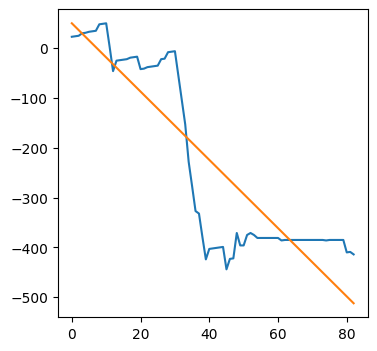



step = 16670: loss = 95.8307113647461


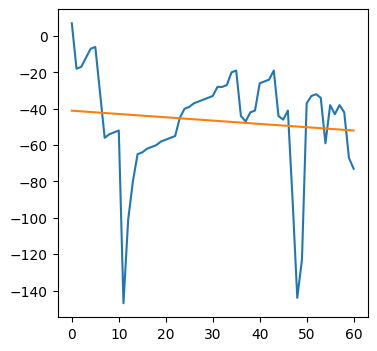



step = 16680: loss = 90.59967041015625


step = 16690: loss = 112.01814270019531


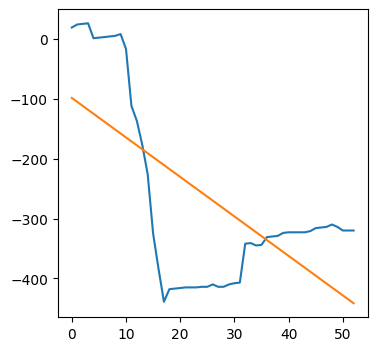



step = 16700: loss = 108.11265563964844


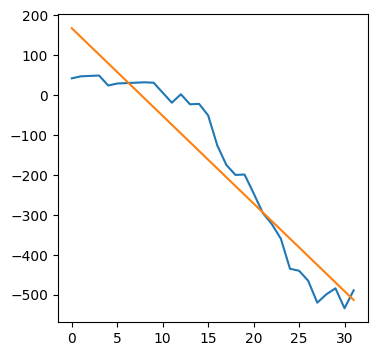



step = 16710: loss = 88.87618255615234


step = 16720: loss = 119.8906478881836
step = 16730: loss = 92.89556884765625




step = 16740: loss = 53.63905715942383


step = 16750: loss = 86.49002075195312
step = 16760: loss = 109.36165618896484


step = 16770: loss = 86.98225402832031


step = 16780: loss = 102.01495361328125


step = 16790: loss = 146.16143798828125
step = 16800: loss = 51.46521759033203


step = 16810: loss = 109.26753997802734


step = 16820: loss = 127.85628509521484
step = 16830: loss = 101.69928741455078


step = 16840: loss = 91.65265655517578


step = 16850: loss = 120.01851654052734


step = 16860: loss = 74.03439331054688


step = 16870: loss = 102.96023559570312
step = 16880: loss = 144.44517517089844


step = 16890: loss = 65.06919860839844


step = 16900: loss = 78.19133758544922




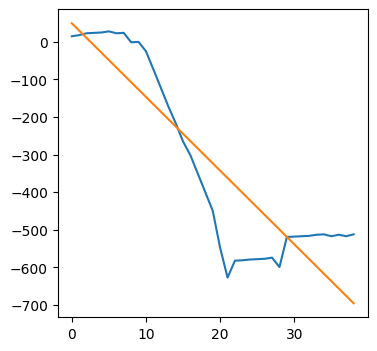



step = 16910: loss = 80.54222106933594
step = 16920: loss = 92.944091796875


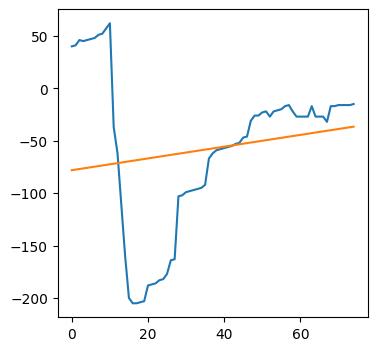



step = 16930: loss = 59.626121520996094


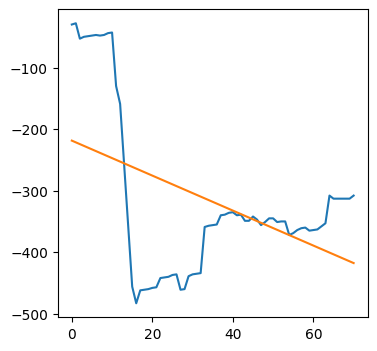



step = 16940: loss = 111.4079818725586
step = 16950: loss = 72.39165496826172


step = 16960: loss = 78.54273223876953


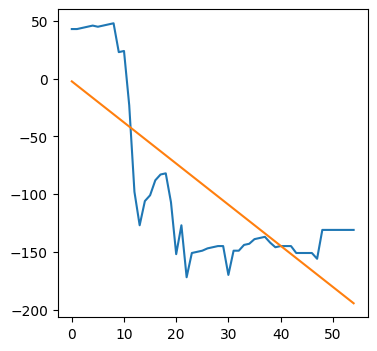



step = 16970: loss = 123.05554962158203


step = 16980: loss = 86.06647491455078


step = 16990: loss = 106.30492401123047


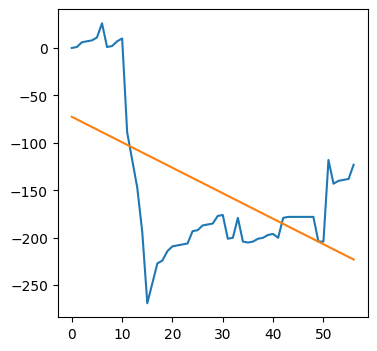



step = 17000: loss = 97.67632293701172


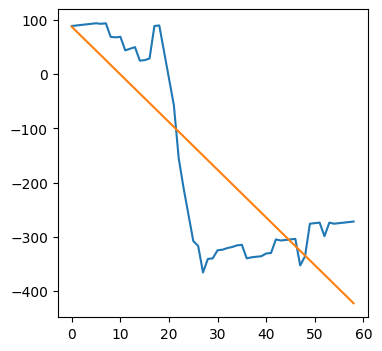



step = 17010: loss = 87.97704315185547
step = 17020: loss = 102.81354522705078


step = 17030: loss = 105.17842864990234


step = 17040: loss = 68.96460723876953
step = 17050: loss = 97.1751480102539


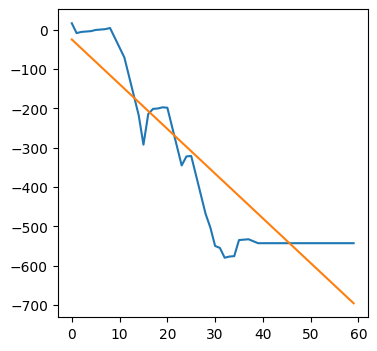



step = 17060: loss = 75.2514877319336


step = 17070: loss = 87.85247039794922


step = 17080: loss = 71.9180679321289


step = 17090: loss = 83.29525756835938


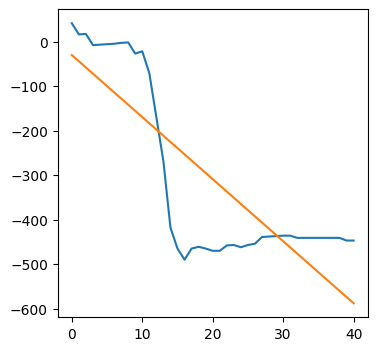



step = 17100: loss = 76.0143051147461


step = 17110: loss = 84.26826477050781


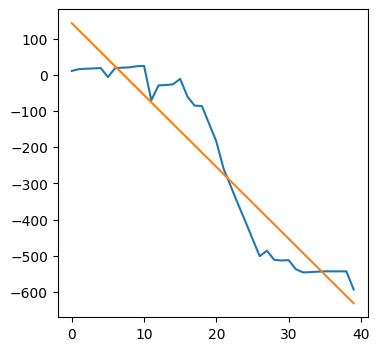





step = 17120: loss = 77.48350524902344


step = 17130: loss = 111.92696380615234
step = 17140: loss = 89.12332153320312


step = 17150: loss = 104.19105529785156


step = 17160: loss = 94.94464111328125


step = 17170: loss = 101.42961120605469


step = 17180: loss = 107.13919830322266


step = 17190: loss = 86.75588989257812


step = 17200: loss = 108.5888671875


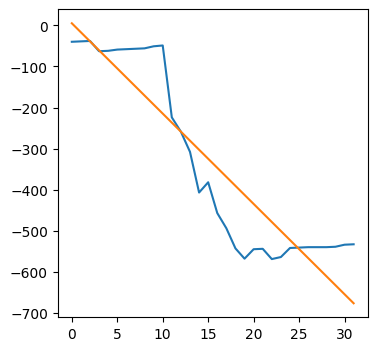



step = 17210: loss = 101.32013702392578


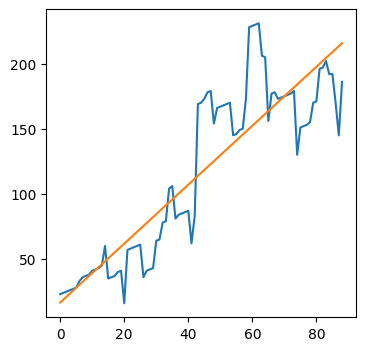



step = 17220: loss = 83.71573638916016
step = 17230: loss = 114.22628784179688


step = 17240: loss = 90.53804779052734


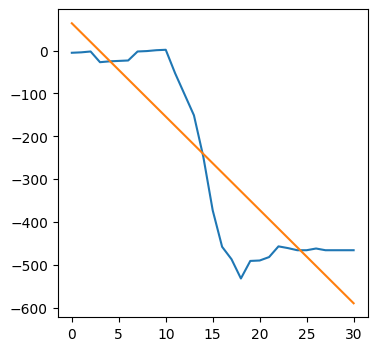



step = 17250: loss = 101.95394897460938


step = 17260: loss = 77.2514877319336


step = 17270: loss = 92.78824615478516


step = 17280: loss = 99.20687866210938


step = 17290: loss = 85.9553451538086


step = 17300: loss = 101.95512390136719


step = 17310: loss = 119.91473388671875


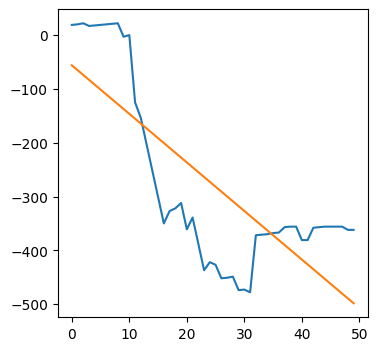



step = 17320: loss = 95.85798645019531




step = 17330: loss = 59.65504837036133
step = 17340: loss = 82.27680206298828


step = 17350: loss = 82.37124633789062


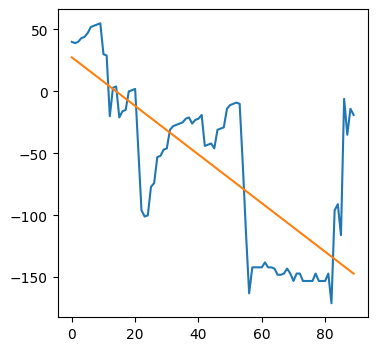



step = 17360: loss = 79.42171478271484
step = 17370: loss = 99.2955322265625


step = 17380: loss = 66.94335174560547
step = 17390: loss = 90.26009368896484


step = 17400: loss = 96.18174743652344


step = 17410: loss = 125.11842346191406
step = 17420: loss = 64.29725646972656


step = 17430: loss = 82.11261749267578


step = 17440: loss = 120.73133850097656
step = 17450: loss = 159.56060791015625


step = 17460: loss = 104.39102172851562


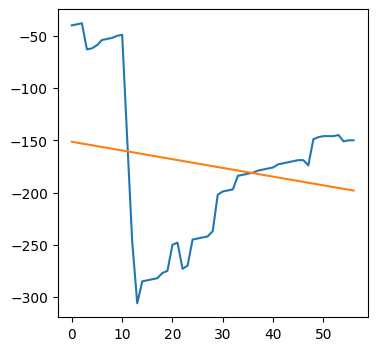



step = 17470: loss = 116.1463394165039


step = 17480: loss = 66.938720703125


step = 17490: loss = 70.4122314453125


step = 17500: loss = 41.53105545043945


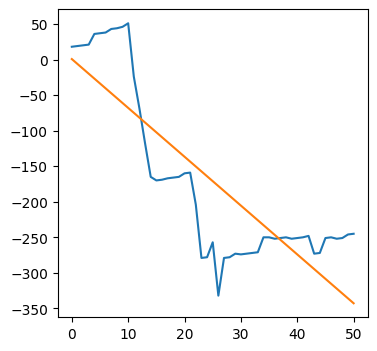



step = 17510: loss = 110.97770690917969
step = 17520: loss = 130.84286499023438


step = 17530: loss = 86.59628295898438


step = 17540: loss = 103.10906219482422


step = 17550: loss = 105.29256439208984


step = 17560: loss = 76.13015747070312
step = 17570: loss = 76.70491027832031


step = 17580: loss = 69.87653350830078


step = 17590: loss = 100.94135284423828


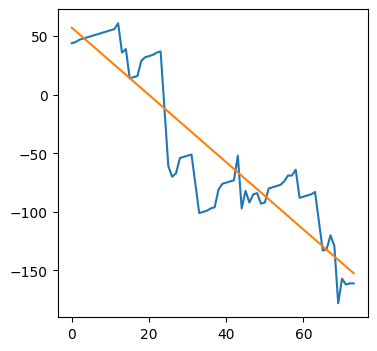



step = 17600: loss = 80.95734405517578
step = 17610: loss = 117.04780578613281


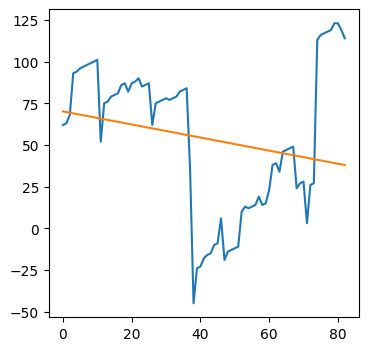



step = 17620: loss = 68.38375854492188


step = 17630: loss = 112.12890625


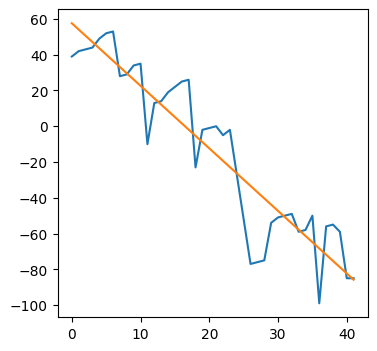





step = 17640: loss = 119.33845520019531
step = 17650: loss = 86.85769653320312


step = 17660: loss = 89.20158386230469
step = 17670: loss = 82.1171875




step = 17680: loss = 108.29617309570312


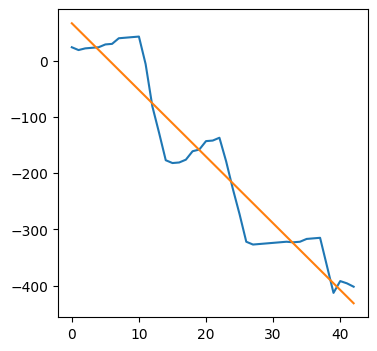



step = 17690: loss = 117.34384155273438
step = 17700: loss = 68.5945053100586




step = 17710: loss = 67.96460723876953
step = 17720: loss = 79.45770263671875


step = 17730: loss = 78.54528045654297


step = 17740: loss = 93.39421081542969
step = 17750: loss = 69.97786712646484


step = 17760: loss = 60.02104949951172


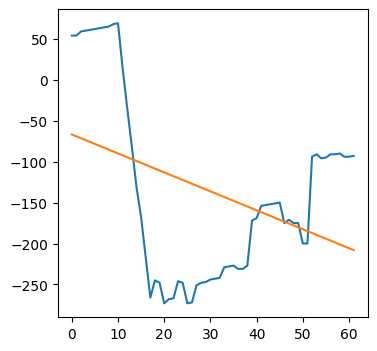



step = 17770: loss = 136.1538848876953


step = 17780: loss = 92.85564422607422


step = 17790: loss = 101.9464340209961


step = 17800: loss = 147.1425323486328




step = 17810: loss = 87.35324096679688


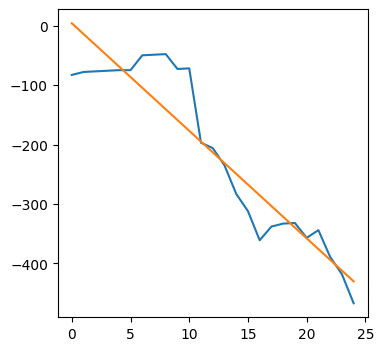



step = 17820: loss = 94.35758209228516


step = 17830: loss = 88.56498718261719
step = 17840: loss = 98.49662780761719


step = 17850: loss = 113.7363510131836


step = 17860: loss = 106.40918731689453


step = 17870: loss = 92.19116973876953
step = 17880: loss = 57.31605529785156


step = 17890: loss = 96.87842559814453


step = 17900: loss = 116.43351745605469
step = 17910: loss = 50.999053955078125


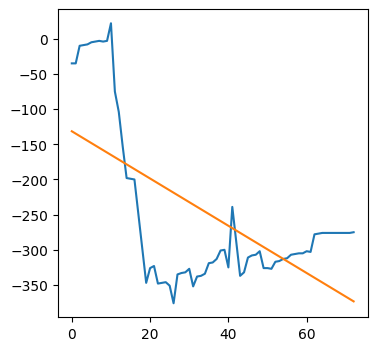



step = 17920: loss = 101.56185150146484


step = 17930: loss = 93.8060302734375


step = 17940: loss = 89.96388244628906


step = 17950: loss = 126.11144256591797


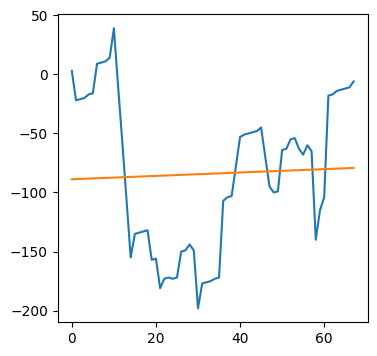



step = 17960: loss = 113.32839965820312
step = 17970: loss = 128.73887634277344


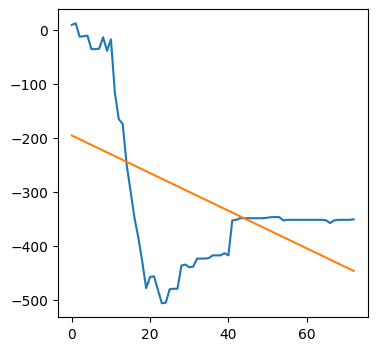



step = 17980: loss = 57.88558578491211
step = 17990: loss = 121.30746459960938


step = 18000: loss = 80.80905151367188


step = 18010: loss = 77.35633850097656


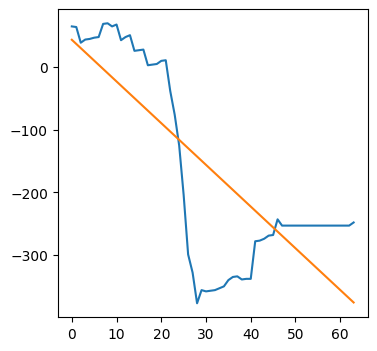



step = 18020: loss = 76.56287384033203


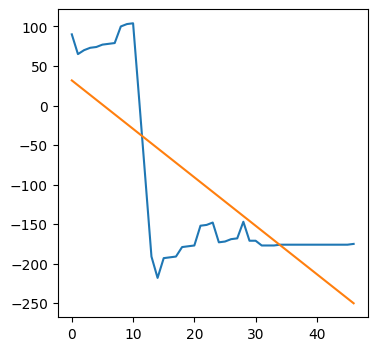



step = 18030: loss = 91.48155212402344


step = 18040: loss = 104.47901916503906
step = 18050: loss = 95.14594268798828


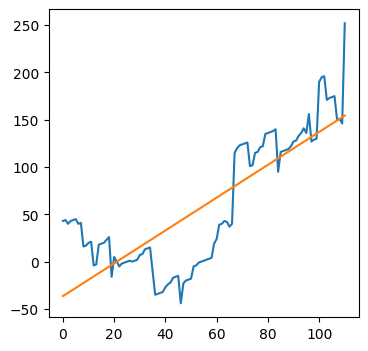



step = 18060: loss = 103.43151092529297


step = 18070: loss = 57.212650299072266
step = 18080: loss = 67.74784851074219


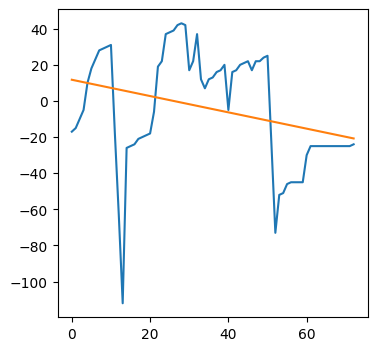



step = 18090: loss = 87.53443908691406


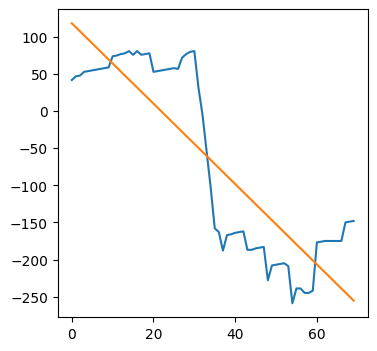



step = 18100: loss = 97.97724151611328


step = 18110: loss = 78.55126190185547
step = 18120: loss = 77.08917236328125


step = 18130: loss = 91.62247467041016


step = 18140: loss = 96.81719970703125


step = 18150: loss = 57.372737884521484


step = 18160: loss = 98.83988952636719


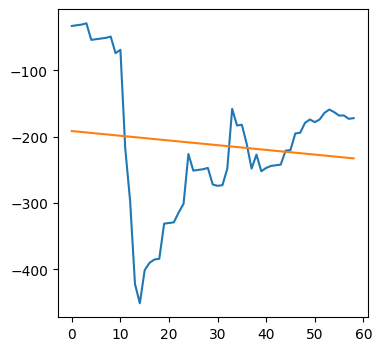



step = 18170: loss = 103.05585479736328


step = 18180: loss = 83.11214447021484


step = 18190: loss = 73.3534164428711


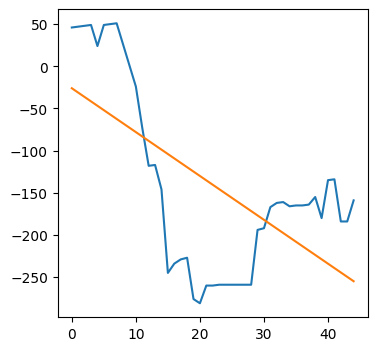



step = 18200: loss = 98.62529754638672


step = 18210: loss = 123.20431518554688


step = 18220: loss = 120.80220031738281


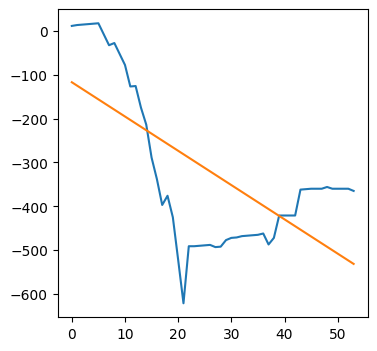



step = 18230: loss = 118.82691192626953


step = 18240: loss = 115.58917999267578


step = 18250: loss = 96.17708587646484
step = 18260: loss = 79.91313171386719


step = 18270: loss = 105.58152770996094


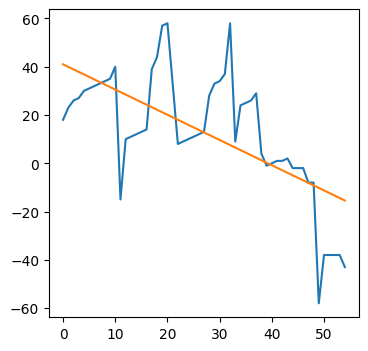



step = 18280: loss = 76.37744903564453


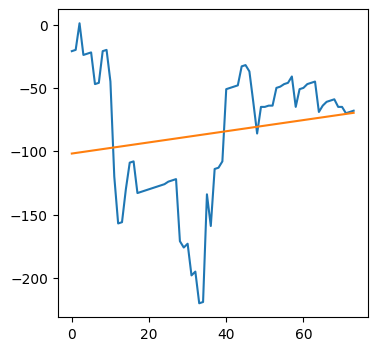



step = 18290: loss = 88.8261947631836
step = 18300: loss = 65.32991790771484


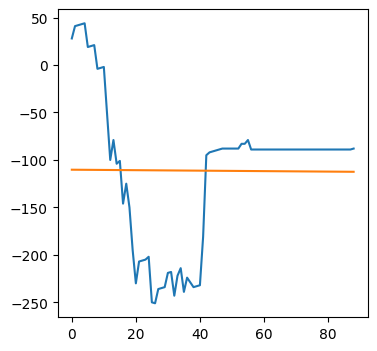



step = 18310: loss = 133.4835968017578


step = 18320: loss = 102.65990447998047


step = 18330: loss = 67.79022979736328
step = 18340: loss = 119.54286193847656


step = 18350: loss = 81.66585540771484
step = 18360: loss = 88.53789520263672


step = 18370: loss = 109.24302673339844


step = 18380: loss = 103.02523040771484




step = 18390: loss = 98.22672271728516
step = 18400: loss = 86.43791198730469


step = 18410: loss = 85.37738800048828


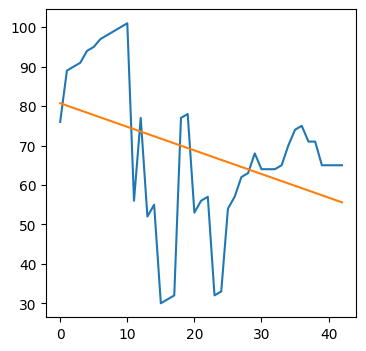



step = 18420: loss = 97.3598403930664


step = 18430: loss = 118.8170166015625


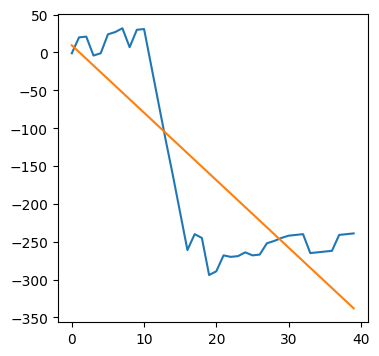



step = 18440: loss = 65.2843017578125




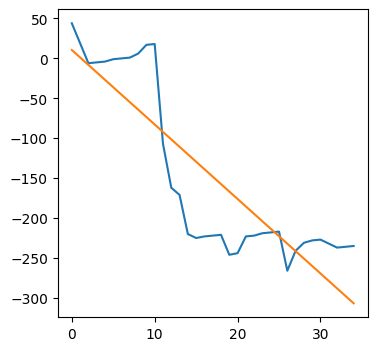



step = 18450: loss = 105.41120147705078


step = 18460: loss = 81.1975326538086


step = 18470: loss = 67.12459564208984


step = 18480: loss = 80.72164916992188


step = 18490: loss = 119.74893951416016




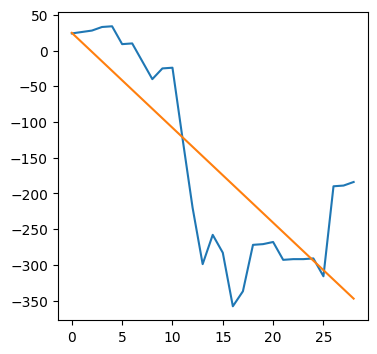



step = 18500: loss = 81.84111022949219
step = 18510: loss = 83.79942321777344


step = 18520: loss = 88.34220123291016


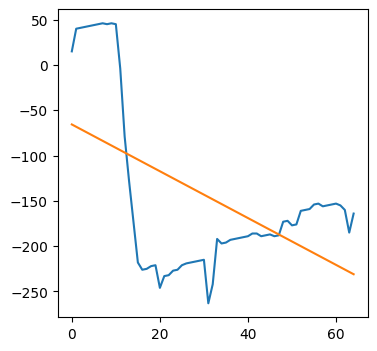



step = 18530: loss = 100.50312042236328


step = 18540: loss = 116.8105697631836


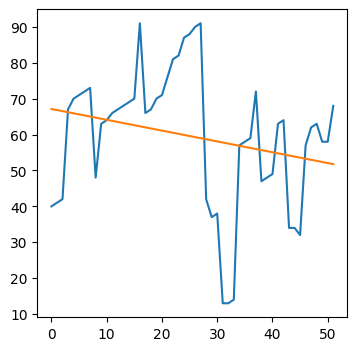



step = 18550: loss = 60.58182907104492


step = 18560: loss = 112.90200805664062


step = 18570: loss = 69.16409301757812


step = 18580: loss = 100.12895202636719


step = 18590: loss = 90.74828338623047


step = 18600: loss = 104.35709381103516


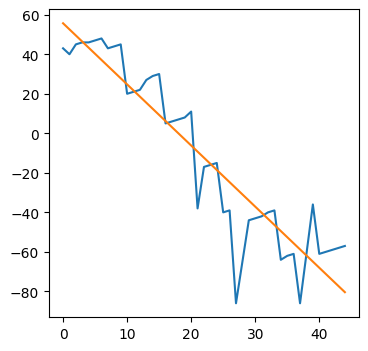



step = 18610: loss = 83.2222900390625


step = 18620: loss = 84.94202423095703


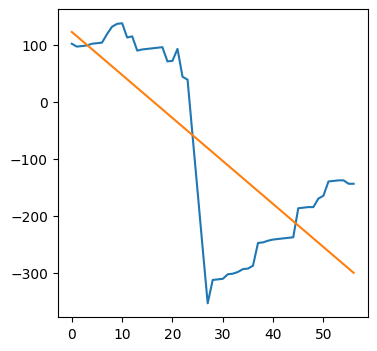



step = 18630: loss = 61.76765823364258


step = 18640: loss = 88.24960327148438




step = 18650: loss = 91.12492370605469
step = 18660: loss = 91.65997314453125


step = 18670: loss = 84.34839630126953
step = 18680: loss = 134.15170288085938


step = 18690: loss = 91.53067016601562


step = 18700: loss = 91.3155517578125


step = 18710: loss = 73.57008361816406
step = 18720: loss = 113.32906341552734


step = 18730: loss = 80.54932403564453


step = 18740: loss = 106.52568817138672


step = 18750: loss = 113.5401611328125
step = 18760: loss = 78.32673645019531


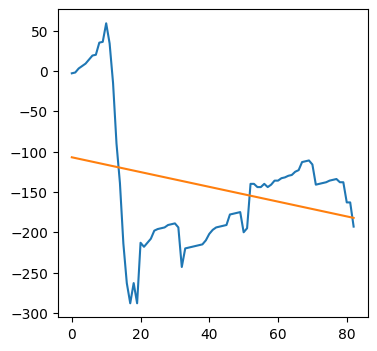



step = 18770: loss = 77.52862548828125


step = 18780: loss = 67.147705078125


step = 18790: loss = 151.83621215820312
step = 18800: loss = 88.93589782714844


step = 18810: loss = 78.86923217773438


step = 18820: loss = 105.75533294677734
step = 18830: loss = 77.16010284423828


step = 18840: loss = 71.28535461425781


step = 18850: loss = 101.05386352539062


step = 18860: loss = 82.75643157958984


step = 18870: loss = 58.91645812988281


step = 18880: loss = 99.04728698730469


step = 18890: loss = 116.6822280883789


step = 18900: loss = 88.9936752319336


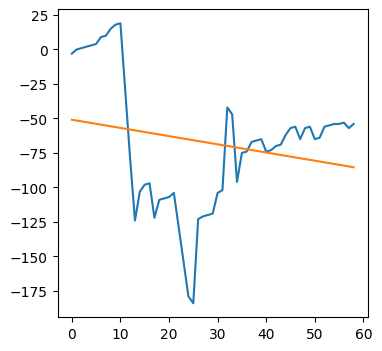



step = 18910: loss = 168.86973571777344
step = 18920: loss = 116.01933288574219


step = 18930: loss = 88.52505493164062


step = 18940: loss = 78.48321533203125


step = 18950: loss = 102.08979797363281


step = 18960: loss = 104.88370513916016
step = 18970: loss = 89.46984100341797


step = 18980: loss = 90.79293060302734
step = 18990: loss = 69.69511413574219
step = 19000: loss = 80.56106567382812


step = 19010: loss = 88.36782836914062


step = 19020: loss = 160.8883056640625
step = 19030: loss = 66.66522979736328




step = 19040: loss = 98.64301300048828


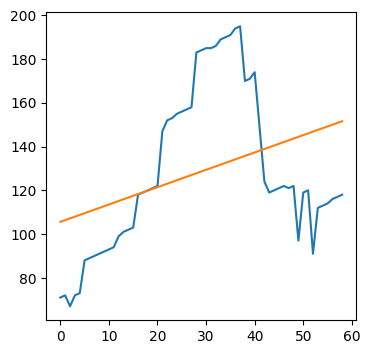



step = 19050: loss = 100.77783966064453


step = 19060: loss = 103.6417236328125


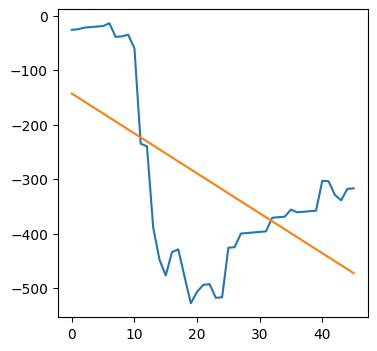



step = 19070: loss = 85.33464813232422


step = 19080: loss = 95.27393341064453
step = 19090: loss = 67.01441192626953


step = 19100: loss = 108.51133728027344


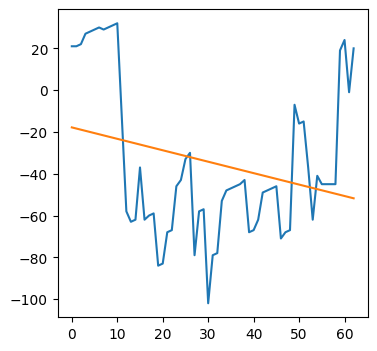



step = 19110: loss = 71.7862319946289


step = 19120: loss = 89.8009262084961
step = 19130: loss = 60.93600082397461


step = 19140: loss = 137.95721435546875


step = 19150: loss = 85.16838836669922




step = 19160: loss = 105.6501693725586
step = 19170: loss = 90.95050048828125




step = 19180: loss = 72.50131225585938
step = 19190: loss = 79.9898452758789


step = 19200: loss = 101.26283264160156




step = 19210: loss = 133.30506896972656


step = 19220: loss = 74.64312744140625
step = 19230: loss = 65.52924346923828




step = 19240: loss = 107.6125259399414
step = 19250: loss = 99.86561584472656


step = 19260: loss = 71.43923950195312


step = 19270: loss = 106.63447570800781


step = 19280: loss = 82.0911636352539
step = 19290: loss = 86.00849151611328




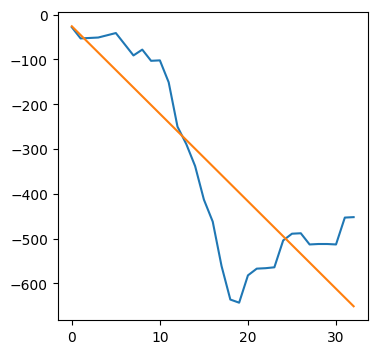



step = 19300: loss = 101.09554290771484
step = 19310: loss = 90.91142272949219


step = 19320: loss = 86.43913269042969


step = 19330: loss = 103.069091796875
step = 19340: loss = 102.78209686279297


step = 19350: loss = 138.47634887695312


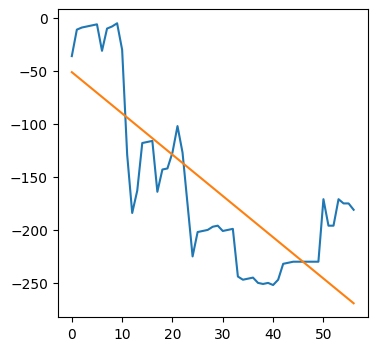



step = 19360: loss = 65.27625274658203


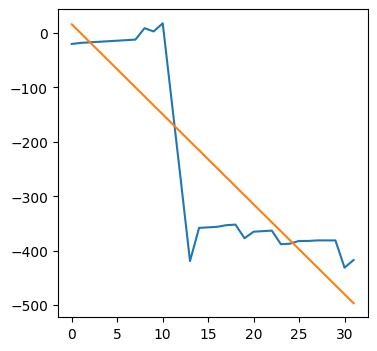





step = 19370: loss = 86.99694061279297
step = 19380: loss = 97.63372802734375




step = 19390: loss = 115.4475326538086


step = 19400: loss = 110.19644927978516


step = 19410: loss = 67.35964965820312


step = 19420: loss = 63.55556106567383


step = 19430: loss = 100.03951263427734


step = 19440: loss = 104.96006774902344


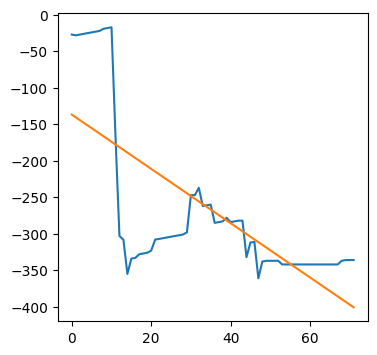



step = 19450: loss = 103.6197509765625


step = 19460: loss = 99.099609375


step = 19470: loss = 95.03104400634766


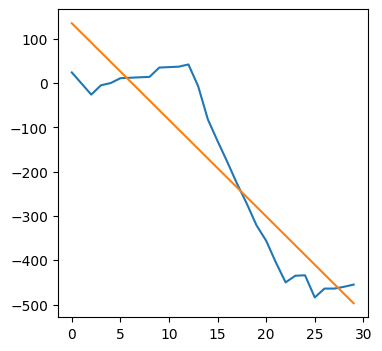



step = 19480: loss = 44.26775360107422


step = 19490: loss = 107.23734283447266
step = 19500: loss = 94.20465087890625


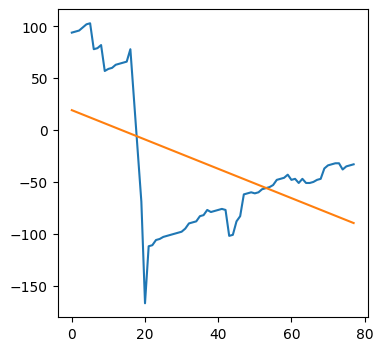

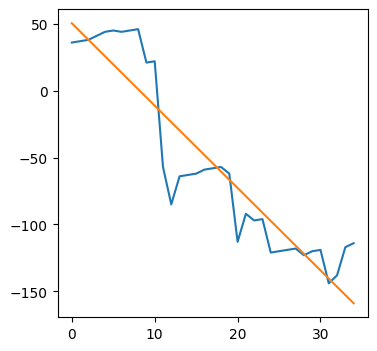



step = 19510: loss = 129.4049835205078
step = 19520: loss = 72.10659790039062


step = 19530: loss = 73.42353820800781


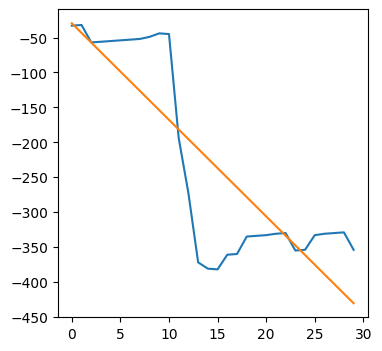



step = 19540: loss = 85.50700378417969


step = 19550: loss = 95.9466323852539


step = 19560: loss = 82.64766693115234


step = 19570: loss = 85.36408233642578


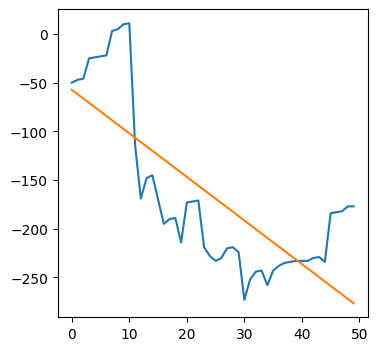



step = 19580: loss = 111.39202117919922


step = 19590: loss = 126.82682800292969




step = 19600: loss = 109.1756591796875


step = 19610: loss = 86.795654296875


step = 19620: loss = 129.38046264648438


step = 19630: loss = 72.80751037597656


step = 19640: loss = 95.2701416015625


step = 19650: loss = 102.95166015625


step = 19660: loss = 105.72767639160156
step = 19670: loss = 92.42591094970703


step = 19680: loss = 105.67324829101562


step = 19690: loss = 91.49280548095703


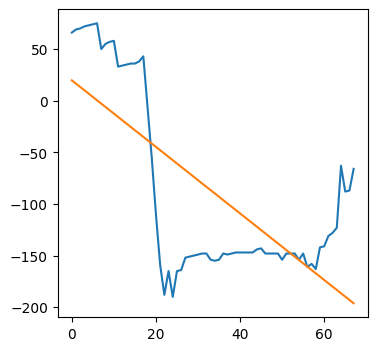



step = 19700: loss = 99.4791030883789


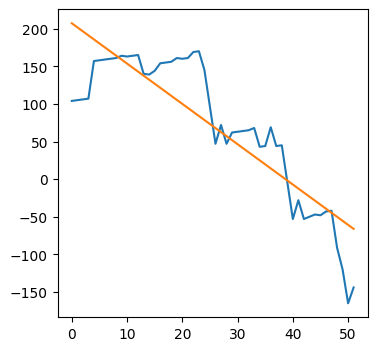



step = 19710: loss = 61.059539794921875


step = 19720: loss = 72.08980560302734


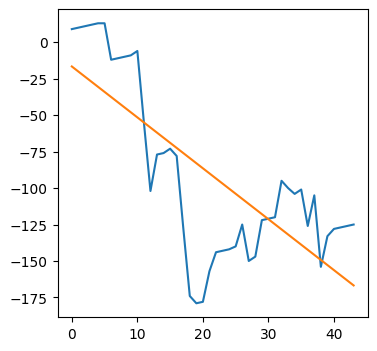



step = 19730: loss = 108.64862060546875
step = 19740: loss = 69.8786392211914


step = 19750: loss = 112.24978637695312


step = 19760: loss = 105.5215835571289


step = 19770: loss = 74.05782318115234


step = 19780: loss = 115.41680145263672


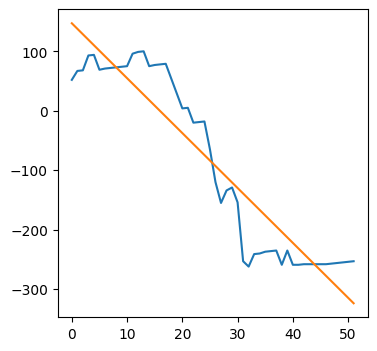



step = 19790: loss = 88.10115814208984


step = 19800: loss = 70.12569427490234


step = 19810: loss = 78.06806945800781




step = 19820: loss = 140.75930786132812


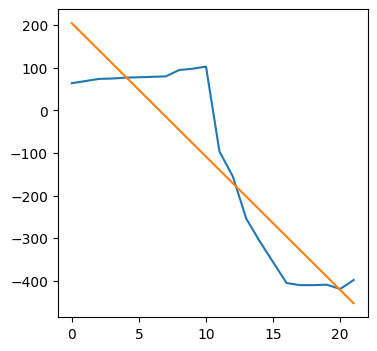



step = 19830: loss = 77.65564727783203


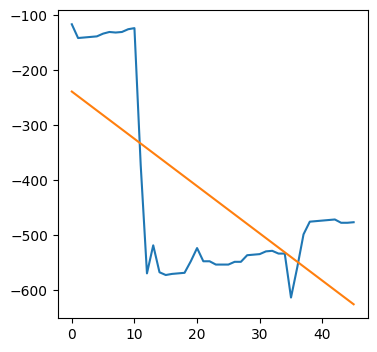



step = 19840: loss = 131.0821990966797


step = 19850: loss = 132.93203735351562
step = 19860: loss = 83.08132934570312


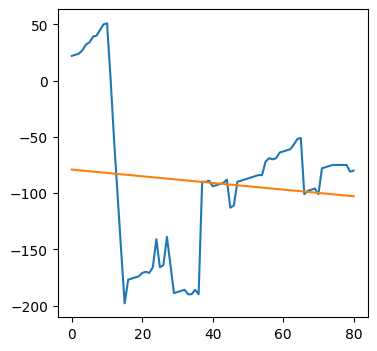



step = 19870: loss = 72.27238464355469


step = 19880: loss = 80.59156799316406


step = 19890: loss = 89.9421615600586


step = 19900: loss = 71.29641723632812


step = 19910: loss = 70.9505386352539


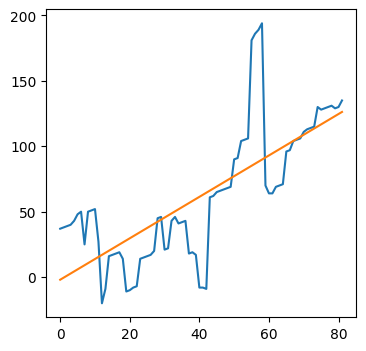



step = 19920: loss = 74.683837890625


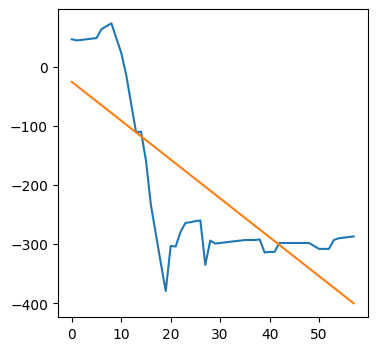



step = 19930: loss = 84.42503356933594


step = 19940: loss = 113.34247589111328


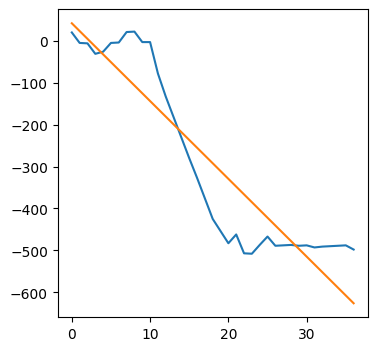



step = 19950: loss = 122.91585540771484


step = 19960: loss = 108.4916000366211


step = 19970: loss = 95.9138412475586


step = 19980: loss = 103.27522277832031


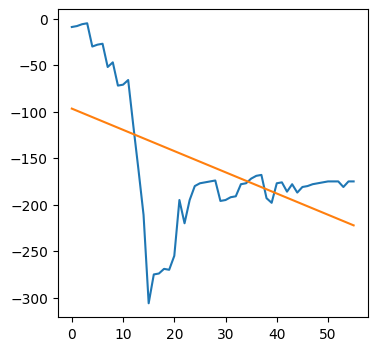



step = 19990: loss = 77.81157684326172
step = 20000: loss = 62.03415298461914


In [ ]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = tf_agents.trajectories.trajectory.from_transition(time_step, action_step,next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

random_policy = tf_agents.policies.random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec())

replay_buffer = tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=100,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using
# TF function.
tf_agent.train = tf_agents.utils.common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, 3)
returns = [avg_return]

for _ in range(20000):
    for _ in range(5):
        collect_step(train_env, tf_agent.collect_policy, replay_buffer)

    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience).loss

    step = tf_agent.train_step_counter.numpy()

    if step % 10 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    #if step % 2 == 0:
    #    avg_return = compute_avg_return(eval_env, tf_agent.policy,3)
    #    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    #    returns.append(avg_return)

**Pytorch Version**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import random
import numpy as np
from collections import deque

BATCH_SIZE = 50

class QNet(nn.Module):
    def __init__(self, input_size=37, hidden_size=62, output_size=36):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = F.leaky_relu(self.linear4(x))
        x = F.leaky_relu(self.linear5(x))
        x = F.softmax(self.linear6(x))
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)
        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))
            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

class Agent:
    def __init__(self):
        self.nGames = 0        
        self.memory = deque(maxlen=100000)
        self.model = QNet()
        self.trainer = QTrainer(self.model, lr=0.0012, gamma=0.9)

    def get_state(self, game):        
        return np.array([ord(i) for i in np.array(game.matrix).reshape(36).tolist()]+[ord(game.actual)])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state, matrix, actual):
        prediction = self.model(torch.tensor(state, dtype=torch.float))
        for i in range(len(matrix)):
          for j in range(len(matrix[0])):
            prediction[6*i+j]*=((matrix[i][j]==".") ^ (actual=="w"))
        
        final_move = torch.argmax(prediction).item()
        final_move = [final_move//6 if final_move!=36 else 5, final_move%6] 
        return final_move

def train():
    total_score = 0
    record = 0
    agent = Agent()
    game = MainGame()
    while True:
        state_old = agent.get_state(game)
        coordinates = tuple(agent.get_action(state_old, game.matrix, game.actual))
        # perform move and get new state
        reward = sum(game.objects[j][1] for i in game.matrix for j in i)
        game.updateMatrix(coordinates)
        game.updateActual()
        game.turn+=1
        game.bigFoots = [[i[0], i[1]+1, i[2]] for i in game.bigFoots]
        game.score.append(sum(game.objects[j][1] for i in game.matrix for j in i))
        reward = game.score[-1]-reward+game.linReg(np.array(list(range(len(game.score)))), game.score)[0]*len(game.score)        
        done = not (any("." in x for x in game.matrix))
        state_new = agent.get_state(game)

        agent.train_short_memory(state_old, coordinates, reward, state_new, done)
        agent.remember(state_old, coordinates, reward, state_new, done)

        if done:
            if agent.nGames%4 == 0:
              game.showGame()
              game.plotScore()  
            # train long memory, plot result, RESET GAME
            random.seed()
            game.checkAndLoadFiles()
            game.turn = 0
            game.score = []
            game.bigFoots = [[(i,j), 0, False] for i in range(len(game.matrix)) for j in range(len(game.matrix[0])) if game.matrix[i][j]=="1"]
            game.updateActual()
            
            agent.nGames += 1
            agent.train_long_memory()
            agent.model.save()

            print('Game', agent.nGames, 'Record:', record)

if __name__ == '__main__':
    train()